## Initial analysis to help support NOAA COM/CPO FY23 Proposal 

In [1]:
# Load libraries

# # Plotting utils 
import datetime
import glob
import os
import time
import warnings
from datetime import date, timedelta
import metpy.calc as mpc
from metpy import interpolate
from metpy.units import units
import numpy as np
import pandas as pd
import scipy.stats as stats
import xarray as xr
import seaborn as sns
warnings.filterwarnings('ignore')
## Import Ngl with pyn_env active 
# import Ngl


import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util
import matplotlib as matplotlib
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable



In [2]:
def preprocess_LES(ds):
    keepVars = ['XTIME','AVS_SH','AVS_LH','AVS_LWP','AVS_RAIN','AVP_QC','AVP_QV',
                'AVP_Z','AVP_P','AVP_THL','AVP_TH','AVP_LWC','AVP_IWC']
    
    dsTimes = ds.Times.load()
    
    times = []
    for iT in range(len(dsTimes.values)):
        timeNow = datetime.datetime.strptime(dsTimes.astype(str).values[iT], '%Y-%m-%d_%H:%M:%S')
        times   = np.append(times, timeNow)

    ds = ds.assign_coords({"Time": times, 
                           "west_east": (ds.west_east.load().values)*0.250,
                           "south_north": (ds.south_north.load().values)*0.250})
    
    ## Convert to local time and drop first time 
    ds['Time'] = ds['Time'].values - np.timedelta64(5, 'h') # And convert to local time by -5hrs 

#     iTimes = np.where(testDS['Time'].values >= (testDS['Time'].values[0] + np.timedelta64(1, 'h')) )[0]
#     testDS = testDS.isel(Time=iTimes)
    
    return ds[keepVars].load()


In [3]:
def regrid_data(fromthis, tothis, method=1):
    """Regrid data using various different methods"""

    #Import necessary modules:
    import xarray as xr

    if method == 1:
        # kludgy: spatial regridding only, seems like can't automatically deal with time
        if 'time' in fromthis.coords:
            result = [fromthis.isel(time=t).interp_like(tothis) for t,time in enumerate(fromthis['time'])]
            result = xr.concat(result, 'time')
            return result
        else:
            return fromthis.interp_like(tothis)
    elif method == 2:
        newlat = tothis['lat']
        newlon = tothis['lon']
        coords = dict(fromthis.coords)
        coords['lat'] = newlat
        coords['lon'] = newlon
        return fromthis.interp(coords)
    elif method == 3:
        newlat = tothis['lat']
        newlon = tothis['lon']
        ds_out = xr.Dataset({'lat': newlat, 'lon': newlon})
        regridder = xe.Regridder(fromthis, ds_out, 'bilinear')
        return regridder(fromthis)
    elif method==4:
        # geocat
        newlat = tothis['lat']
        newlon = tothis['lon']
        result = geocat.comp.linint2(fromthis, newlon, newlat, False)
        result.name = fromthis.name
        
        return result

# LES stuff

## Read in data

In [4]:
forcingFile  = '/glade/work/mdfowler/CLASP/clasp-htg.bdate.nc'
forcDS       = xr.open_dataset(forcingFile, decode_times=True)

## Convert to local time
localTimes  = forcDS['time'].values - np.timedelta64(5,'h')
forcDS      = forcDS.assign_coords({"time": localTimes})

## Can we get a measure of vertically integrated moisture/temperature convergence? 
g = 9.8 
vertInt_T_adv_h = np.zeros([len(forcDS.time.values)])
vertInt_Q_adv_h = np.zeros([len(forcDS.time.values)])

for iP in range(len(forcDS.lev.values)-1):
    dP = (forcDS.lev.values[iP]-forcDS.lev.values[iP+1])*100.0 # Convert from hPa to Pa

    ## Adding a negative sign outside of the advective terms - 
    ##   These are the values of T and Q divergence, so their negative is *convergence* and easier to interpret
    vertInt_Tadv_levl = dP*(-forcDS.T_adv_h.values[:,iP,0,0]/3600.0) # Convert T_adv units from K/hr to K/s
    vertInt_Qadv_levl = dP*(-forcDS.q_adv_h.values[:,iP,0,0]/3600.0) # Convert Q_adv units from g/kg/hr to g/kg/s

    # Sum over all the levels 
    vertInt_T_adv_h = vertInt_T_adv_h + vertInt_Tadv_levl
    vertInt_Q_adv_h = vertInt_Q_adv_h + vertInt_Qadv_levl

vertInt_T_adv_h = vertInt_T_adv_h/g
vertInt_Q_adv_h = vertInt_Q_adv_h/g

forcDS['vertInt_T_adv_h'] = (('time'), vertInt_T_adv_h)
forcDS['vertInt_Q_adv_h'] = (('time'), vertInt_Q_adv_h)




Read in the secondary circulation metric that Jason's calculated, and the files with the domain-wide averaged higher order moments. 

In [5]:
circulationTXT = '/glade/work/mdfowler/CLASP/LESdata_fromJason/circulations.txt'

circMetric = pd.read_csv(circulationTXT, sep=" ", header=None)
circMetric.columns = ['dateVal', 'metricVal']

allYears   = [] 
allMonths  = []
allDays    = []

for iDate in range(len(circMetric.dateVal)):
    allYears   = np.append(allYears,   circMetric.dateVal.values.astype(str)[iDate][0:4]) 
    allMonths  = np.append(allMonths, circMetric.dateVal.values.astype(str)[iDate][4:6])
    allDays    = np.append(allDays, circMetric.dateVal.values.astype(str)[iDate][6::])



In [6]:
lesDir        = '/glade/work/mdfowler/CLASP/LESdata_fromJason/allDays_250mRes/'

## Fix time arrays to be useful in the LES cases
startTime = datetime.datetime(2016,1,1, 0,0,0)

# Empty arrays: 
dateStringsUsed   = []
circMetric_daysUsed = []
circMetric_daysUsed_defMatch = []
daysWithDefault = []
dailymax_LES_thl2 = []

## Counter for how many days have default output
numDaysDefault = 0
dayCounts = 0 

for iDay in range(len(allYears)): 
     
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    ## First: read LES data (surface thl2 and qv2) 
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    dateString = allYears[iDay]+allMonths[iDay]+allDays[iDay]
    
    
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    ## Get LES data
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    HTGds_allVars = xr.open_dataset(lesDir+'trimfr2_'+dateString+'_00.nc', decode_times=False)
    HMGds_allVars = xr.open_dataset(lesDir+'trimfr2_'+dateString+'_01.nc', decode_times=False)

    HTGds_allVars = HTGds_allVars.assign_coords({"case": 'HTG'})
    HMGds_allVars = HMGds_allVars.assign_coords({"case": 'HMG'})

    LES_allVars = xr.concat([HMGds_allVars, HTGds_allVars], "case")



    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    ## Just a few more processing steps 
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

    ## Get a better time dimension to use  (LES)
    times_LESday = [] 
    for iT in range(len(LES_allVars.time.values)): 
        timeStep     = startTime + timedelta(minutes = int(LES_allVars.time.values[iT])) - timedelta(hours = 5)   ## Also convert to local time 
        times_LESday = np.append(times_LESday, timeStep)


    LES_allVars['datetime'] = (('time'), times_LESday)
    LES_allVars             = LES_allVars.set_index(time='datetime')

    ## Combine into one array 
    if dayCounts==0: 
        LES_allDays_allVars = LES_allVars
    else:
        LES_allDays_allVars = xr.concat([LES_allDays_allVars, LES_allVars], "time")
    dayCounts = dayCounts+1

    del LES_allVars

    print('Done with ', dateString)

    

Done with  20150606
Done with  20150609
Done with  20150627
Done with  20150801
Done with  20150829
Done with  20160518
Done with  20160530
Done with  20160610
Done with  20160611
Done with  20160614
Done with  20160619
Done with  20160625
Done with  20160716
Done with  20160719
Done with  20160720
Done with  20160818
Done with  20160819
Done with  20160830
Done with  20170403
Done with  20170405
Done with  20170509
Done with  20170524
Done with  20170527
Done with  20170605
Done with  20170609
Done with  20170614
Done with  20170626
Done with  20170627
Done with  20170629
Done with  20170630
Done with  20170704
Done with  20170705
Done with  20170709
Done with  20170712
Done with  20170716
Done with  20170717
Done with  20170719
Done with  20170720
Done with  20170721
Done with  20170725
Done with  20170728
Done with  20170802
Done with  20170826
Done with  20170828
Done with  20170830
Done with  20170922
Done with  20170923
Done with  20170924
Done with  20180514
Done with  20180522


In [7]:
## Resample the moments to be hourly (means are listed for the hour they start in; so "8a" =mean over 8a, 8:10, 8:20, etc) 
LES_allDays_allVarsHr         = LES_allDays_allVars.resample(time='1H').mean(dim='time').dropna(dim='time')
LES_allDays_allVars30m        = LES_allDays_allVars.resample(time='30Min').mean(dim='time').dropna(dim='time')

## Add thirty minutes to match the other LES output better 
LES_allDays_allVarsHr['time'] = LES_allDays_allVarsHr['time'] + np.timedelta64(30, 'm')

## For consistency with default LES cases, let's also only get means through hour 21
iHrsSel               = np.where(LES_allDays_allVarsHr['time.hour'].values<22)[0]
LES_allDays_allVarsHr = LES_allDays_allVarsHr.isel(time=iHrsSel)


Read in the 'default' LES variables that are available on the Duke server

In [8]:
newLESdefDir = '/glade/campaign/cgd/tss/mdfowler/CLASP_LES_data/hydrology.cee.duke.edu/'
HTGdirs      = np.sort(glob.glob(newLESdefDir+'fr2_*_00'))
HMGdirs      = np.sort(glob.glob(newLESdefDir+'fr2_*_01'))


for iHTG in range(len(HTGdirs)):
    filesHTG  = np.sort(glob.glob(HTGdirs[iHTG]+'/*.nc4'))
    
    htgLESnew = xr.open_mfdataset(filesHTG,  preprocess=preprocess_LES, concat_dim='Time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')

    if iHTG==0:
        HTGnew_allDays = htgLESnew
    else:
        HTGnew_allDays = xr.concat([HTGnew_allDays, htgLESnew], "Time")
    
    
    
for iHMG in range(len(HMGdirs)):    
    filesHMG = np.sort(glob.glob(HMGdirs[iHMG]+'/*.nc4'))

    hmgLESnew = xr.open_mfdataset(filesHMG,  preprocess=preprocess_LES, concat_dim='Time', 
                                    combine='nested', decode_times=False, 
                                    data_vars='minimal')
    
    if iHMG==0:
        HMGnew_allDays = hmgLESnew
    else:
        HMGnew_allDays = xr.concat([HMGnew_allDays, hmgLESnew], "Time")
        

print('Done reading in new LES cases')

HTGnew_allDays = HTGnew_allDays.assign_coords({"case": 'HTG'})
HMGnew_allDays = HMGnew_allDays.assign_coords({"case": 'HMG'})

LES_newDefault = xr.concat([HMGnew_allDays, HTGnew_allDays], "case")


Done reading in new LES cases


In [9]:
## Drop the first hour (7a) - this is just the initial state, not LES simulated 
iHrsSel        = np.where(LES_newDefault['Time.hour'].values>7)[0]
LES_newDefault = LES_newDefault.isel(Time=iHrsSel)

## LES times were recorded at the *end* of the hour, so just shift into the hour's mean they represent 
LES_newDefault['Time'] = LES_newDefault.Time - np.timedelta64(30, 'm')


In [10]:
uniqDays_LES  = LES_newDefault.sel(case='HMG').resample(Time='1D').mean().dropna(dim='Time').Time.values
uniqDays_moms = LES_allDays_allVarsHr.sel(case='HMG').resample(time='1D').mean().dropna(dim='time').time.values

print('Number of days in LES default data: ', len(uniqDays_LES))
print('Number of ', len(uniqDays_moms))
print('Number of overlapping days: ', len(list(set(uniqDays_LES) & set(uniqDays_moms) )))

Number of days in LES default data:  92
Number of  92
Number of overlapping days:  92


## Look into HTG vs HMG differences

Get total TKE in the LES simulations

In [11]:
## u2 and v2 are on the same vertical grid, but w2 is not. Problem is that I don't have pressure levels for 
##    those inbetween levels 

## Interpolate w2 to those heights? 
hgtGoal = LES_allDays_allVarsHr.z
hgtNow  = LES_allDays_allVarsHr.zw

interpW2 = np.full([len(LES_allDays_allVarsHr.time.values),
                    len(LES_allDays_allVarsHr.case.values), len(LES_allDays_allVarsHr.k.values)], np.nan)

for iCase in range(len(LES_allDays_allVarsHr.case.values)): 
    for iT in range(len(LES_allDays_allVarsHr.time.values)):
        zTime = hgtGoal[iT,:].isel(case=iCase).values
        zNow  = hgtNow[iT,:].isel(case=iCase).values
        w2Now = LES_allDays_allVarsHr.w2.isel(case=iCase).values[iT,:]

        interpW2[iT, iCase, :] = interpolate.interpolate_1d(zTime, zNow, w2Now)

LES_allDays_allVarsHr['interp_w2'] = (('time','case','k'), interpW2)
TKE_total = LES_allDays_allVarsHr.u2.values + LES_allDays_allVarsHr.v2.values + LES_allDays_allVarsHr.interp_w2.values

LES_allDays_allVarsHr['TKE_total'] = (('time','case','k'), TKE_total)


In [12]:
LESmeanRain     = LES_newDefault['AVS_RAIN'].mean(("south_north", "west_east"))
LES_newDefault['meanRain'] = (('case','Time'), LESmeanRain*3600)  ## Convert units to mm/hr, not mm/s


Get hourly means and some way of estimating significance

In [13]:
hourlyMean_LESdef  = LES_newDefault.groupby('Time.hour').mean(dim='Time')
hourlyStd_LESdef   = LES_newDefault.groupby('Time.hour').std(dim='Time')
hourlyCount_LESdef = LES_newDefault.groupby('Time.hour').count(dim='Time')
hourlySE_LESdef    = hourlyStd_LESdef/np.sqrt(hourlyCount_LESdef)

hourlyMean_LESmom  = LES_allDays_allVarsHr.groupby('time.hour').mean(dim='time')
hourlyStd_LESmom   = LES_allDays_allVarsHr.groupby('time.hour').std(dim='time')
hourlyCount_LESmom = LES_allDays_allVarsHr.groupby('time.hour').count(dim='time')
hourlySE_LESmom    = hourlyStd_LESmom/np.sqrt(hourlyCount_LESmom)


In [14]:
CIlevel = 1.960   ## 95% CI
# CIlevel = 1.645   ## 90% CI

Text(0, 0.5, 'mm/hr')

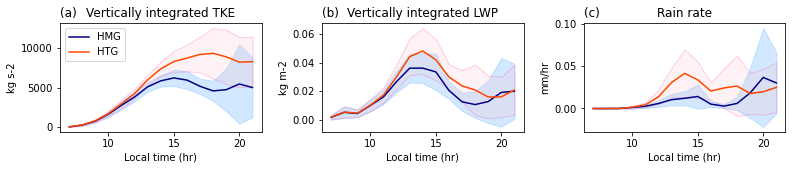

In [33]:
## Plot differences in the annual cycle of rainfall 

fig,axs = plt.subplots(1,3, figsize=(13,2))
axs     = axs.ravel()
fig.subplots_adjust(wspace=0.3)


## TKE 
axs[0].plot(hourlyMean_LESmom.hour.values, hourlyMean_LESmom.sel(case='HMG').tke.values, '-', color='navy', label='HMG')
axs[0].fill_between(hourlyMean_LESmom.hour.values, 
                 hourlyMean_LESmom.sel(case='HMG').tke.values - (CIlevel*hourlySE_LESmom.sel(case='HMG').tke.values), 
                 hourlyMean_LESmom.sel(case='HMG').tke.values + (CIlevel*hourlySE_LESmom.sel(case='HMG').tke.values),
                 alpha=0.2, facecolor='dodgerblue',edgecolor='dodgerblue')
axs[0].plot(hourlyMean_LESmom.hour.values, hourlyMean_LESmom.sel(case='HTG').tke.values, '-', color='orangered', label='HTG')
axs[0].fill_between(hourlyMean_LESmom.hour.values, 
                 hourlyMean_LESmom.sel(case='HTG').tke.values - (CIlevel*hourlySE_LESmom.sel(case='HTG').tke.values), 
                 hourlyMean_LESmom.sel(case='HTG').tke.values + (CIlevel*hourlySE_LESmom.sel(case='HTG').tke.values),
                 alpha=0.2, facecolor='pink',edgecolor='deeppink')
axs[0].legend(loc='upper left')
axs[0].set_title('(a) ', loc='left')
axs[0].set_title('Vertically integrated TKE')
axs[0].set_xlabel('Local time (hr)')
axs[0].set_ylabel(LES_allDays_allVars.tke.units)


## LWP
axs[1].plot(hourlyMean_LESmom.hour.values, hourlyMean_LESmom.sel(case='HMG').lwp.values, '-', color='navy', label='HMG')
axs[1].fill_between(hourlyMean_LESmom.hour.values, 
                 hourlyMean_LESmom.sel(case='HMG').lwp.values - (CIlevel*hourlySE_LESmom.sel(case='HMG').lwp.values), 
                 hourlyMean_LESmom.sel(case='HMG').lwp.values + (CIlevel*hourlySE_LESmom.sel(case='HMG').lwp.values),
                 alpha=0.2, facecolor='dodgerblue',edgecolor='dodgerblue')
axs[1].plot(hourlyMean_LESmom.hour.values, hourlyMean_LESmom.sel(case='HTG').lwp.values, '-', color='orangered', label='HTG')
axs[1].fill_between(hourlyMean_LESmom.hour.values, 
                 hourlyMean_LESmom.sel(case='HTG').lwp.values - (CIlevel*hourlySE_LESmom.sel(case='HTG').lwp.values), 
                 hourlyMean_LESmom.sel(case='HTG').lwp.values + (CIlevel*hourlySE_LESmom.sel(case='HTG').lwp.values),
                 alpha=0.2, facecolor='pink',edgecolor='deeppink')
# axs[1].legend()
axs[1].set_title('(b) ', loc='left')
axs[1].set_title('Vertically integrated LWP')
axs[1].set_xlabel('Local time (hr)')
axs[1].set_ylabel(LES_allDays_allVars.lwp.units)


## Grid mean rainfall
axs[2].plot(hourlyMean_LESdef.hour.values, hourlyMean_LESdef.sel(case='HMG').meanRain.values, color='navy', label='HMG')
axs[2].fill_between(hourlyMean_LESdef.hour.values, 
                 hourlyMean_LESdef.sel(case='HMG').meanRain.values - (CIlevel*hourlySE_LESdef.sel(case='HMG').meanRain.values), 
                 hourlyMean_LESdef.sel(case='HMG').meanRain.values + (CIlevel*hourlySE_LESdef.sel(case='HMG').meanRain.values),
                 alpha=0.2, facecolor='dodgerblue',edgecolor='dodgerblue')
axs[2].plot(hourlyMean_LESdef.hour.values, hourlyMean_LESdef.sel(case='HTG').meanRain.values, color='orangered', label='HTG')
axs[2].fill_between(hourlyMean_LESdef.hour.values, 
                 hourlyMean_LESdef.sel(case='HTG').meanRain.values - (CIlevel*hourlySE_LESdef.sel(case='HTG').meanRain.values), 
                 hourlyMean_LESdef.sel(case='HTG').meanRain.values + (CIlevel*hourlySE_LESdef.sel(case='HTG').meanRain.values),
                 alpha=0.2, facecolor='pink',edgecolor='deeppink')
# axs[2].legend()
axs[2].set_title('(c) ', loc='left')
axs[2].set_title('Rain rate')
axs[2].set_xlabel('Local time (hr)')
# axs[2].set_ylabel(LES_newDefault.AVS_RAIN.units)
axs[2].set_ylabel('mm/hr')

# axs[0].rcParams.update({'font.size': 14})


[None, None, None, None]

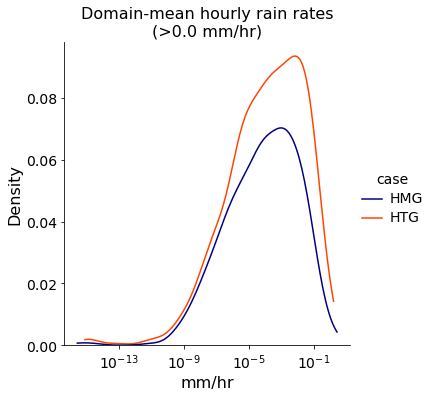

In [23]:
# Define dataframe

rainRatesHMG = LES_newDefault.meanRain.sel(case='HMG').values
rainRatesHMG = rainRatesHMG[np.where(rainRatesHMG>0)[0]]

rainRatesHTG = LES_newDefault.meanRain.sel(case='HTG').values
rainRatesHTG = rainRatesHTG[np.where(rainRatesHTG>0)[0]]

# dfReal = pd.concat(axis=0, ignore_index=True, objs=[
#          pd.DataFrame.from_dict({'Rain rate': np.squeeze(LES_newDefault.meanRain.sel(case='HMG').values), 'case': 'HMG'}),
#          pd.DataFrame.from_dict({'Rain rate': np.squeeze(LES_newDefault.meanRain.sel(case='HTG').values), 'case': 'HTG'}),
# ])

dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHMG), 'case': 'HMG'}),
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHTG), 'case': 'HTG'}),
])

# Make plot 
g = sns.displot(dfReal, x='Rain rate', hue='case', kind='kde', height=5, cut=0, 
                log_scale=True,
# g = sns.displot(dfReal, x='Rain rate', hue='case', kind='ecdf', height=8, 
                palette=['navy','orangered'])


# g.ax.set_xlim([0,0.5])
g.ax.set_title("Domain-mean hourly rain rates\n(>0.0 mm/hr)", fontsize=16 ) 
g.ax.set_xlabel('mm/hr',fontsize=16)
g.ax.set_ylabel('Density',fontsize=16)
g.ax.tick_params(axis='both', labelsize= 14)
plt.setp(g._legend.get_title(), fontsize=14)
plt.setp(g._legend.get_texts(), fontsize=14)


[None, None, None, None]

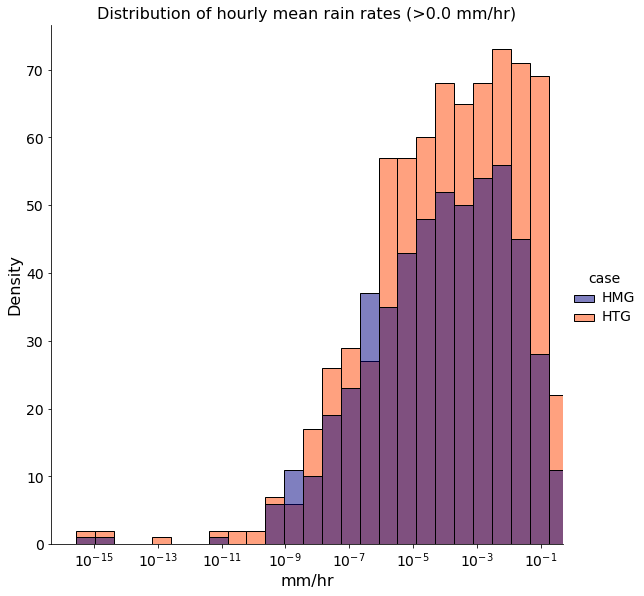

In [50]:
# Define dataframe

rainRatesHMG = LES_newDefault.meanRain.sel(case='HMG').values
rainRatesHMG = rainRatesHMG[np.where(rainRatesHMG>0)[0]]

rainRatesHTG = LES_newDefault.meanRain.sel(case='HTG').values
rainRatesHTG = rainRatesHTG[np.where(rainRatesHTG>0)[0]]

# dfReal = pd.concat(axis=0, ignore_index=True, objs=[
#          pd.DataFrame.from_dict({'Rain rate': np.squeeze(LES_newDefault.meanRain.sel(case='HMG').values), 'case': 'HMG'}),
#          pd.DataFrame.from_dict({'Rain rate': np.squeeze(LES_newDefault.meanRain.sel(case='HTG').values), 'case': 'HTG'}),
# ])

dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHMG), 'case': 'HMG'}),
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHTG), 'case': 'HTG'}),
])

# Make plot 
g = sns.displot(dfReal, x='Rain rate', hue='case', kind='hist', height=8, 
                log_scale=True,
# g = sns.displot(dfReal, x='Rain rate', hue='case', kind='ecdf', height=8, 
                palette=['navy','orangered'])


g.ax.set_xlim([0,0.5])
g.ax.set_title("Distribution of hourly mean rain rates (>0.0 mm/hr)", fontsize=16 ) 
g.ax.set_xlabel('mm/hr',fontsize=16)
g.ax.set_ylabel('Density',fontsize=16)
g.ax.tick_params(axis='both', labelsize= 14)
plt.setp(g._legend.get_title(), fontsize=14)
plt.setp(g._legend.get_texts(), fontsize=14)


[None, None, None, None]

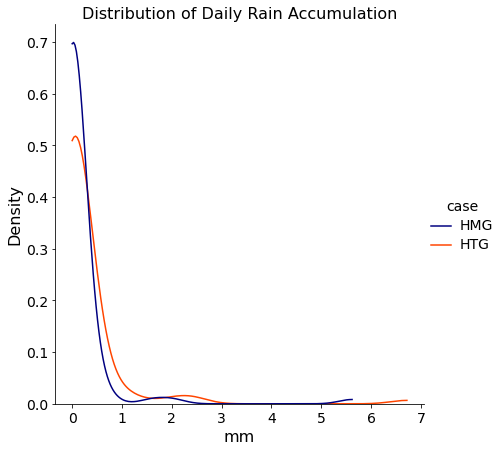

In [19]:
dailyRainSum = LES_newDefault.meanRain.resample(Time='1D').sum(dim='Time').dropna(dim='Time') 

# Define dataframe
dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(dailyRainSum.sel(case='HMG').values), 'case': 'HMG'}),
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(dailyRainSum.sel(case='HTG').values), 'case': 'HTG'}),
])

# Make plot 
g = sns.displot(dfReal, x='Rain rate', hue='case', kind='kde', height=6, cut=0,
                palette=['navy','orangered'])

# g = sns.displot(dfReal, x='Rain rate', hue='case', kind='hist', height=8,
#                 palette=['navy','orangered'])


# g.ax.set_xlim([0,0.5])
g.ax.set_title("Distribution of Daily Rain Accumulation", fontsize=16 ) 
g.ax.set_xlabel('mm',fontsize=16)
g.ax.set_ylabel('Density',fontsize=16)
g.ax.tick_params(axis='both', labelsize= 14)
plt.setp(g._legend.get_title(), fontsize=14)
plt.setp(g._legend.get_texts(), fontsize=14)



Text(0.5, 0, 'HMG')

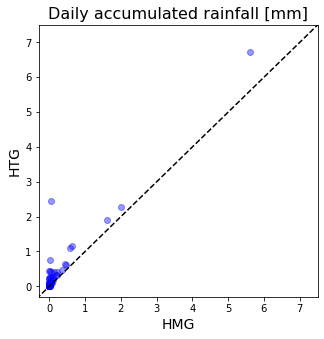

In [44]:
fig,axs = plt.subplots(1,1,figsize=(5,5))

axs.plot(dailyRainSum.sel(case='HMG').values, dailyRainSum.sel(case='HTG').values,'bo',alpha=0.4)
axs.plot(np.arange(-1,8,0.1), np.arange(-1,8,0.1),'k--')
axs.set_xlim([-0.3,7.5])
axs.set_ylim([-0.3,7.5])

axs.set_title('Daily accumulated rainfall [mm]', fontsize=16)
axs.set_ylabel('HTG', fontsize=14)
axs.set_xlabel('HMG', fontsize=14)


In [17]:
rainRatesHMG = LES_newDefault.AVS_RAIN.sel(case='HMG').values
rainRatesHMG = rainRatesHMG.reshape([np.shape(rainRatesHMG)[0]*np.shape(rainRatesHMG)[1]*np.shape(rainRatesHMG)[2],1])
np.shape(rainRatesHMG)

(373152000, 1)

[None, None, None, None]

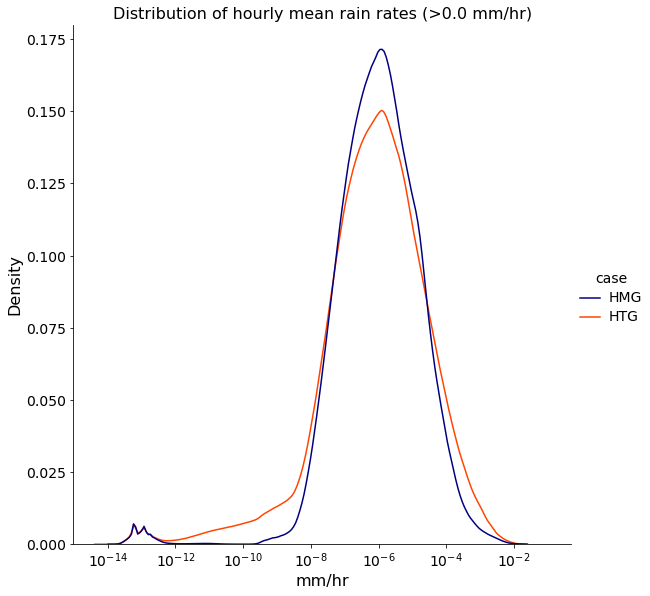

In [18]:
# Define dataframe

rainRatesHMG = LES_newDefault.AVS_RAIN.sel(case='HMG').values
rainRatesHMG = rainRatesHMG.reshape([np.shape(rainRatesHMG)[0]*np.shape(rainRatesHMG)[1]*np.shape(rainRatesHMG)[2],1])
rainRatesHMG = rainRatesHMG[np.where(rainRatesHMG>0)[0]]

rainRatesHTG = LES_newDefault.AVS_RAIN.sel(case='HTG').values
rainRatesHTG = rainRatesHTG.reshape([np.shape(rainRatesHTG)[0]*np.shape(rainRatesHTG)[1]*np.shape(rainRatesHTG)[2],1])
rainRatesHTG = rainRatesHTG[np.where(rainRatesHTG>0)[0]]

# dfReal = pd.concat(axis=0, ignore_index=True, objs=[
#          pd.DataFrame.from_dict({'Rain rate': np.squeeze(LES_newDefault.meanRain.sel(case='HMG').values), 'case': 'HMG'}),
#          pd.DataFrame.from_dict({'Rain rate': np.squeeze(LES_newDefault.meanRain.sel(case='HTG').values), 'case': 'HTG'}),
# ])

dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHMG), 'case': 'HMG'}),
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHTG), 'case': 'HTG'}),
])

# Make plot 
g = sns.displot(dfReal, x='Rain rate', hue='case', kind='kde', height=8, cut=0, 
                log_scale=True,
# g = sns.displot(dfReal, x='Rain rate', hue='case', kind='ecdf', height=8, 
                palette=['navy','orangered'])


g.ax.set_xlim([0,0.5])
g.ax.set_title("Distribution of hourly mean rain rates (>0.0 mm/hr)", fontsize=16 ) 
g.ax.set_xlabel('mm/hr',fontsize=16)
g.ax.set_ylabel('Density',fontsize=16)
g.ax.tick_params(axis='both', labelsize= 14)
plt.setp(g._legend.get_title(), fontsize=14)
plt.setp(g._legend.get_texts(), fontsize=14)


# Global CLASP stuff

In [ ]:
dataDir  = '/glade/campaign/cgd/tss/mdfowler/'   # Moved to more safe storage 

caseHTG  = 'globalCLASP.2000_CAM60_CLM50SP_CICEPRES_DOCNDOM_MOSART_SGLC_SWAV.f09_f09_mg17.HTG_cesm2p2.013'
caseHMG  = 'globalCLASP.2000_CAM60_CLM50SP_CICEPRES_DOCNDOM_MOSART_SGLC_SWAV.f09_f09_mg17.HMG_cesm2p2.013'
caseNone = 'globalCLASP.2000_CAM60_CLM50SP_CICEPRES_DOCNDOM_MOSART_SGLC_SWAV.f09_f09_mg17.NoMoments_cesm2p2.013'
caseHTG10 = 'globalCLASP.2000_CAM60_CLM50SP_CICEPRES_DOCNDOM_MOSART_SGLC_SWAV.f09_f09_mg17.HTG_mult10_cesm2p2.013match'



# Existing precip biases

Data generated by IPCC WGI Interactive Atlas: <br>
https://interactive-atlas.ipcc.ch

In [6]:
dataDir    = '/glade/u/home/mdfowler/temp/'
cmip6_file = dataDir+'CMIP6-TotalPrecipitationPR_mm_day-1981-2010-Annual_34models.nc'
gpcp_file  = dataDir+'GPCP-TotalPrecipitationPR_mm_day-1980-2015_Observations-Annual.nc'

cmip6_ds = xr.open_dataset(cmip6_file)
gpcp_ds  = xr.open_dataset(gpcp_file)


In [25]:
regridCMIP = regrid_data(cmip6_ds, gpcp_ds, method=1)['pr']

bias = regridCMIP-gpcp_ds['pr'].values

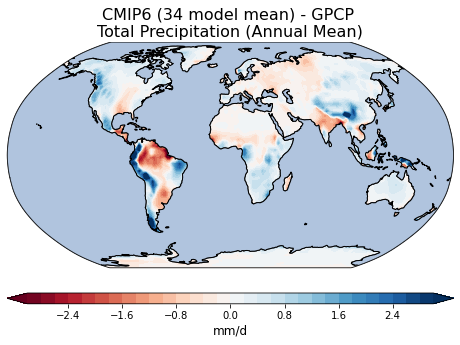

In [43]:
# fig,axs = plt.subplots(1,1, figsize=(12,8), subplot_kw={'projection':ccrs.Robinson(central_longitude=0)})
fig,axs = plt.subplots(1,1, figsize=(8,5), subplot_kw={'projection':ccrs.Robinson(central_longitude=0)})

contour_plot = axs.contourf(regridCMIP.lon.values, regridCMIP.lat.values, np.squeeze(bias), 
                               np.arange(-3, 3.2, 0.2),
                               cmap='RdBu',extend='both',
                               transform=ccrs.PlateCarree())
axs.coastlines()
axs.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k', facecolor='lightsteelblue')
axs.set_title('CMIP6 (34 model mean) - GPCP \nTotal Precipitation (Annual Mean)', fontsize=16)

# Add colorbar
ax_position = axs.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar        = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('mm/d', fontsize=12)


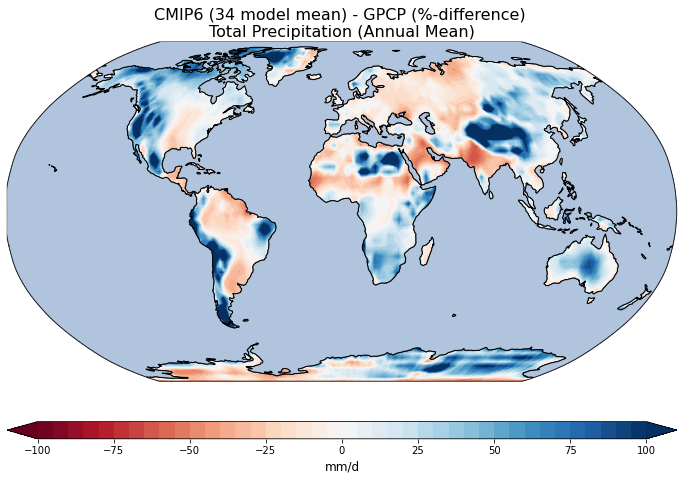

In [46]:
fig,axs = plt.subplots(1,1, figsize=(12,8), subplot_kw={'projection':ccrs.Robinson(central_longitude=0)})
# fig,axs = plt.subplots(1,1, figsize=(8,5), subplot_kw={'projection':ccrs.Robinson(central_longitude=0)})

contour_plot = axs.contourf(regridCMIP.lon.values, regridCMIP.lat.values, 
                            (np.squeeze(bias)/np.squeeze(gpcp_ds['pr'].values))*100, 
                               np.arange(-100, 105, 5),
                               cmap='RdBu',extend='both',
                               transform=ccrs.PlateCarree())
axs.coastlines()
axs.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k', facecolor='lightsteelblue')
axs.set_title('CMIP6 (34 model mean) - GPCP (%-difference) \nTotal Precipitation (Annual Mean)', fontsize=16)

# Add colorbar
ax_position = axs.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar        = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('mm/d', fontsize=12)


# Clustering

In [11]:
import sklearn
from sklearn import preprocessing
import seaborn as sns
sns.set_theme()


In [12]:
## Select just certain data 

selMonth = 6

iJJA = np.where((forcDS['time.month'].values>=6) & (forcDS['time.month'].values<=8))[0]
forcDS_JJA = forcDS.isel(time=iJJA, lat=0, lon=0)

iMornings = np.where((forcDS_JJA['time.hour'].values>=7) & (forcDS_JJA['time.hour'].values<=10) )[0]
forcDS_JJAmorn = forcDS_JJA.isel(time=iMornings)

iAfternoon= np.where((forcDS_JJA['time.hour'].values>=12) & (forcDS_JJA['time.hour'].values<=18) )[0]
forcDS_JJAnoon = forcDS_JJA.isel(time=iAfternoon)

iNearSfc = np.where( (forcDS['lev'].values>=700) )[0]
forcDS_JJAmornPBL = forcDS_JJAmorn.isel(lev=iNearSfc)


In [13]:
mornMean = forcDS_JJAmorn.resample(time='1D').mean().dropna(dim='time')
noonMean = forcDS_JJAnoon.resample(time='1D').mean().dropna(dim='time')
mornMeanPBL = forcDS_JJAmornPBL.resample(time='1D').mean().dropna(dim='time')


In [14]:
## Normalize...
X = mornMeanPBL.q.values
# X = mornMeanPBL.T.values

# Fit the scaler object:
scaler = preprocessing.StandardScaler()
scaler = scaler.fit(X)

# The mean and std profiles are in the scaler object properties:
X_ave = scaler.mean_
X_std = scaler.scale_

# Normalize data:
Xn = scaler.transform(X)  


In [38]:
from sklearn.cluster import KMeans

K = 4

km = KMeans(n_clusters = K, n_init = 50, random_state = 1234) 

# Set k 
# Number of times to run algorithm with different centroid seeds; defualt = 10
# Random initialization seed; setting this allows us to reproduce results 

km.fit(Xn)

KMeans(n_clusters=4, n_init=50, random_state=1234)

In [39]:
km.inertia_

1540.001220703125

In [17]:
cluster_centers = km.cluster_centers_

In [355]:
# # Set the figure size
# fig,axs = plt.subplots(1,1,figsize=(6,8))

# #Plot the Clusters
# for iDay in range(len(mornMeanPBL.time.values)):
#     axs.plot(Xn[iDay,:], mornMeanPBL.lev.values, alpha=0.3)
    
# #Plot the Centroids
# for iCentr in range(K): 
#     axs.plot(cluster_centers[iCentr, :], mornMeanPBL.lev.values, 'k-', alpha=0.9)
    
# axs.invert_yaxis()



Text(0.5, 1.0, 'Q profiles: Morning mean (7-10a)')

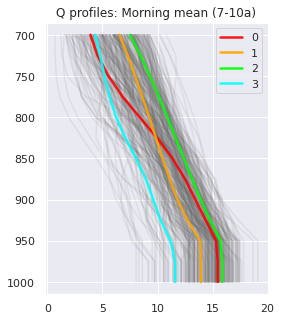

In [18]:
fig,axs = plt.subplots(1,1,figsize=(4,5))

for iDay in range(len(mornMeanPBL.time.values)):
    axs.plot(mornMeanPBL.q.values[iDay,:], mornMeanPBL.lev.values, color='dimgray', alpha=0.1)
    
#Plot the Centroids
denorm_cntr = (cluster_centers*X_std) + X_ave
colors = ['red','orange','lime','cyan','dodgerblue','darkviolet','magenta']

for iCentr in range(K): 
    axs.plot(denorm_cntr[iCentr, :], mornMeanPBL.lev.values, color=colors[iCentr], linewidth=2.5, alpha=0.9, label=str(iCentr))
    
axs.legend()
axs.invert_yaxis()
axs.set_title('Q profiles: Morning mean (7-10a)')
    

In [19]:
pd.Series(km.labels_).value_counts().sort_index()

0     64
1    110
2    109
3     53
dtype: int64

In [37]:
# ## Is there a 'right' number of clusters to use?
# wcss = []
# for k in range(2, 20):        # Iterate over k values of 2 through 10
#     km = KMeans(n_clusters = k, n_init = 50, random_state = 1234)
#     km.fit(Xn)
#     wcss.append(km.inertia_)  # Inertia attributa = WCSS for this km

# wcss_series = pd.Series(wcss, index = range(2, 20))

# plt.figure(figsize=(8, 6))
# ax = sns.lineplot(y = wcss_series, x = wcss_series.index)
# ax = sns.scatterplot(y = wcss_series, x = wcss_series.index, s = 150)
# ax = ax.set(xlabel = 'Number of Clusters (k)', 
#             ylabel = 'Within Cluster Sum of Squares (WCSS)')



In [36]:
# from sklearn.metrics import silhouette_score

# silhouette = []
# for k in range(2, 20):
#     km = KMeans(n_clusters = k, n_init = 50, random_state = 1234)
#     km.fit(Xn)                                           
#     silhouette.append(silhouette_score(Xn, km.labels_))  # Pass data and labels to silhouette_score

# silhouette_series = pd.Series(silhouette, index = range(2, 20))

# plt.figure(figsize=(8, 6))
# ax = sns.lineplot(y = silhouette_series, x = silhouette_series.index)
# ax = sns.scatterplot(y = silhouette_series, x = silhouette_series.index, s = 150)
# ax = ax.set(xlabel = 'Number of Clusters (k)', 
#             ylabel = 'Average Silhouette Score')



In [35]:
# from sklearn.metrics import calinski_harabasz_score

# calinski = []
# for k in range(2, 20):
#     km = KMeans(n_clusters = k, n_init = 50, random_state = 1234)
#     km.fit(Xn)
#     calinski.append(calinski_harabasz_score(Xn, km.labels_))

# calinski_series = pd.Series(calinski, index = range(2, 20))

# plt.figure(figsize=(8, 6))
# ax = sns.lineplot(y = calinski_series, x = calinski_series.index)
# ax = sns.scatterplot(y = calinski_series, x = calinski_series.index, s = 150)
# ax = ax.set(xlabel = 'Number of Clusters (k)', 
#             ylabel = 'Calinski Harabasz Score')


In [40]:
labelDays = km.labels_

In [41]:
mornMeanPBL['labelDays'] = (('time'), labelDays)

In [42]:
def getIndsLES(iClass, matchDS, matchDS_timeName): 
    selDates = mornMeanPBL.isel(time = np.where(mornMeanPBL.labelDays.values==iClass)[0])
    
    # Loop over those dates 
    keepInds = [] 
    
    for iDay in range(len(selDates.time.values)):
        if matchDS_timeName=='Time': 
            iMatch = np.where((matchDS['Time.year'].values  == selDates['time.year'].values[iDay]) &
                              (matchDS['Time.month'].values == selDates['time.month'].values[iDay]) &
                              (matchDS['Time.day'].values   == selDates['time.day'].values[iDay]) )[0]

        else: 
            iMatch = np.where((matchDS['time.year'].values  == selDates['time.year'].values[iDay]) &
                              (matchDS['time.month'].values == selDates['time.month'].values[iDay]) &
                              (matchDS['time.day'].values   == selDates['time.day'].values[iDay]) )[0]
            
        keepInds = np.append(keepInds, iMatch)

        if matchDS_timeName=='Time':
            LESsel = matchDS.isel(Time=keepInds.astype(int))
        else: 
            LESsel = matchDS.isel(time=keepInds.astype(int))
    
    return LESsel

In [43]:
forcDS_class0 = getIndsLES(0, forcDS_JJA, 'time')
forcDS_class1 = getIndsLES(1, forcDS_JJA, 'time')
forcDS_class2 = getIndsLES(2, forcDS_JJA, 'time')
forcDS_class3 = getIndsLES(3, forcDS_JJA, 'time')

# forcDS_class4 = getIndsLES(4, forcDS_JJA, 'time')
# forcDS_class5 = getIndsLES(5, forcDS_JJA, 'time')
# forcDS_class6 = getIndsLES(6, forcDS_JJA, 'time')


Text(0.5, 0, 'thlp2  K2')

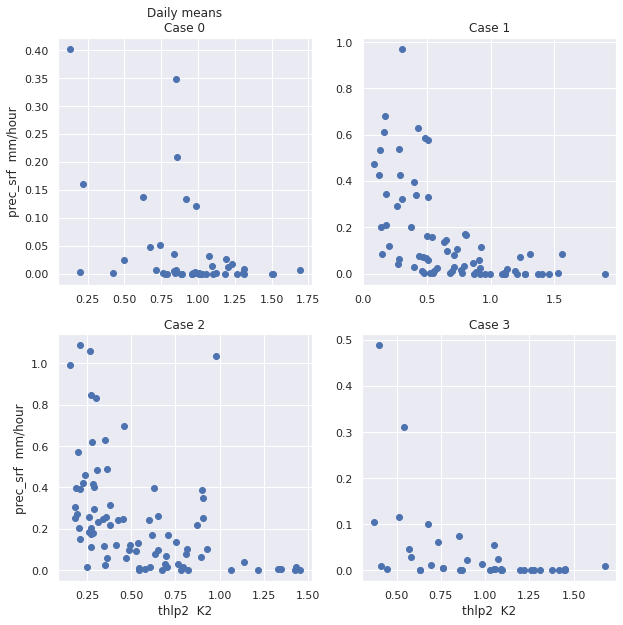

In [44]:
fig,axs = plt.subplots(2,2, figsize=(10,10))
axs     = axs.ravel()

xVar = 'thlp2'
yVar = 'prec_srf'

iReal = np.where(forcDS_class0[xVar].values!=-9999.9)[0]
axs[0].plot(forcDS_class0[xVar].isel(time=iReal).resample(time='1D').mean(dim='time').dropna(dim='time'), 
            forcDS_class0[yVar].isel(time=iReal).resample(time='1D').mean(dim='time').dropna(dim='time'), 'o')
axs[0].set_title('Daily means\nCase 0')
del iReal

iReal = np.where(forcDS_class1[xVar].values!=-9999.9)[0]
axs[1].plot(forcDS_class1[xVar].isel(time=iReal).resample(time='1D').mean(dim='time').dropna(dim='time'), 
            forcDS_class1[yVar].isel(time=iReal).resample(time='1D').mean(dim='time').dropna(dim='time'), 'o')
axs[1].set_title('Case 1')
del iReal

iReal = np.where(forcDS_class2[xVar].values!=-9999.9)[0]
axs[2].plot(forcDS_class2[xVar].isel(time=iReal).resample(time='1D').mean(dim='time').dropna(dim='time'), 
            forcDS_class2[yVar].isel(time=iReal).resample(time='1D').mean(dim='time').dropna(dim='time'), 'o')
axs[2].set_title('Case 2')
del iReal

iReal = np.where(forcDS_class3[xVar].values!=-9999.9)[0]
axs[3].plot(forcDS_class3[xVar].isel(time=iReal).resample(time='1D').mean(dim='time').dropna(dim='time'), 
            forcDS_class3[yVar].isel(time=iReal).resample(time='1D').mean(dim='time').dropna(dim='time'), 'o')
axs[3].set_title('Case 3')
del iReal


axs[0].set_ylabel(yVar +'  '+ forcDS[yVar].units )
axs[2].set_ylabel(yVar +'  '+ forcDS[yVar].units )

axs[2].set_xlabel(xVar +'  '+ forcDS[xVar].units)
axs[3].set_xlabel(xVar +'  '+ forcDS[xVar].units)



Text(0.5, 0, 'qp2  (kg2\\kg2)')

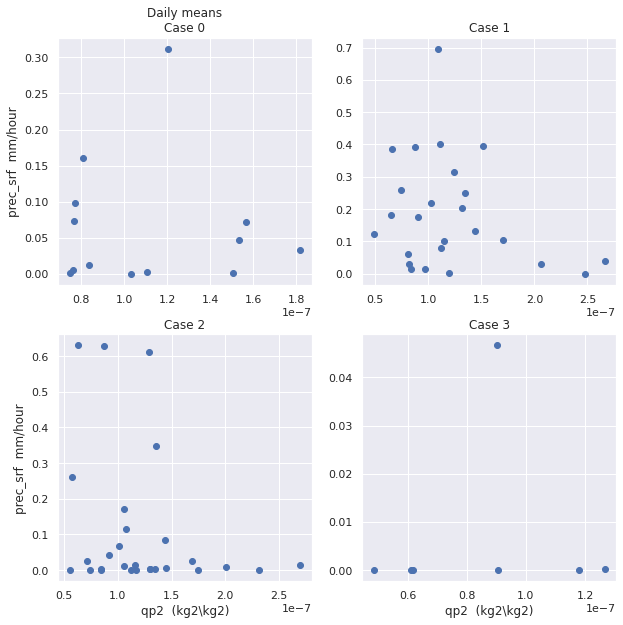

In [57]:
fig,axs = plt.subplots(2,2, figsize=(10,10))
axs     = axs.ravel()

xVar = 'qp2'
yVar = 'prec_srf'

iReal = np.where(forcDS_class0[xVar].values!=-9999.9)[0]
axs[0].plot(forcDS_class0[xVar].isel(time=iReal).resample(time='1D').mean(dim='time').dropna(dim='time'), 
            forcDS_class0[yVar].isel(time=iReal).resample(time='1D').mean(dim='time').dropna(dim='time'), 'o')
axs[0].set_title('Daily means\nCase 0')
del iReal

iReal = np.where(forcDS_class1[xVar].values!=-9999.9)[0]
axs[1].plot(forcDS_class1[xVar].isel(time=iReal).resample(time='1D').mean(dim='time').dropna(dim='time'), 
            forcDS_class1[yVar].isel(time=iReal).resample(time='1D').mean(dim='time').dropna(dim='time'), 'o')
axs[1].set_title('Case 1')
del iReal

iReal = np.where(forcDS_class2[xVar].values!=-9999.9)[0]
axs[2].plot(forcDS_class2[xVar].isel(time=iReal).resample(time='1D').mean(dim='time').dropna(dim='time'), 
            forcDS_class2[yVar].isel(time=iReal).resample(time='1D').mean(dim='time').dropna(dim='time'), 'o')
axs[2].set_title('Case 2')
del iReal

iReal = np.where(forcDS_class3[xVar].values!=-9999.9)[0]
axs[3].plot(forcDS_class3[xVar].isel(time=iReal).resample(time='1D').mean(dim='time').dropna(dim='time'), 
            forcDS_class3[yVar].isel(time=iReal).resample(time='1D').mean(dim='time').dropna(dim='time'), 'o')
axs[3].set_title('Case 3')
del iReal


axs[0].set_ylabel(yVar +'  '+ forcDS[yVar].units )
axs[2].set_ylabel(yVar +'  '+ forcDS[yVar].units )

axs[2].set_xlabel(xVar +'  '+ forcDS[xVar].units)
axs[3].set_xlabel(xVar +'  '+ forcDS[xVar].units)
       


In [367]:
forcDS

<xarray.Dataset>
Dimensions:          (lat: 1, lev: 37, lon: 1, time: 33600)
Coordinates:
  * time             (time) datetime64[ns] 2014-12-31T19:00:00 ... 2018-10-31...
  * lat              (lat) float32 36.61
  * lon              (lon) float32 -97.49
  * lev              (lev) float32 1e+03 975.0 950.0 925.0 ... 150.0 125.0 100.0
Data variables:
    bdate            float64 2.015e+07
    base_time        datetime64[ns] 2015-01-01
    time_offset      (time) datetime64[ns] 2015-01-01 ... 2018-10-31T22:49:25...
    year             (time) float64 2.015e+03 2.015e+03 ... 2.018e+03 2.018e+03
    month            (time) float64 1.0 1.0 1.0 1.0 1.0 ... 10.0 10.0 10.0 10.0
    day              (time) float64 1.0 1.0 1.0 1.0 1.0 ... 31.0 31.0 31.0 31.0
    hour             (time) float64 0.0 1.0 2.0 3.0 4.0 ... 20.0 21.0 22.0 23.0
    minute           (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    alt              (lat, lon) float32 315.0
    phis             (lat, lon) float32 3.087e+03
    T                (time, lev, lat, lon) float32 ...
    q                (time, lev, lat, lon) float32 ...
    u                (time, lev, lat, lon) float32 ...
    v                (time, lev, lat, lon) float32 ...
    omega            (time, lev, lat, lon) float32 ...
    div              (time, lev, lat, lon) float32 ...
    T_adv_h          (time, lev, lat, lon) float32 0.01545 0.01545 ... 0.09207
    T_adv_v          (time, lev, lat, lon) float32 ...
    q_adv_h          (time, lev, lat, lon) float32 0.002741 ... 2.824e-08
    q_adv_v          (time, lev, lat, lon) float32 ...
    s                (time, lev, lat, lon) float32 ...
    s_adv_h          (time, lev, lat, lon) float32 ...
    s_adv_v          (time, lev, lat, lon) float32 ...
    dsdt             (time, lev, lat, lon) float32 ...
    dTdt             (time, lev, lat, lon) float32 ...
    dqdt             (time, lev, lat, lon) float32 ...
    q1               (time, lev, lat, lon) float32 ...
    q2               (time, lev, lat, lon) float32 ...
    prec_srf         (time, lat, lon) float32 0.0 0.0 0.0 ... 0.1668 0.09248
    LH               (time, lat, lon) float32 2.977 3.586 3.884 ... 42.09 37.49
    SH               (time, lat, lon) float32 -1.749 -3.375 ... -3.635 -12.13
    p_srf_aver       (time, lat, lon) float32 986.5 986.4 986.2 ... 969.5 969.2
    p_srf_center     (time, lat, lon) float32 993.4 993.3 993.0 ... 975.5 974.9
    T_srf            (time, lat, lon) float32 -7.161 -7.337 ... 11.87 11.76
    T_soil           (time, lat, lon) float32 2.287 2.255 2.216 ... 14.91 14.85
    RH_srf           (time, lat, lon) float32 57.17 60.04 62.18 ... 58.14 57.75
    wspd_srf         (time, lat, lon) float32 1.346 1.382 1.466 ... 4.201 4.201
    u_srf            (time, lat, lon) float32 0.7117 0.659 ... -1.472 -1.452
    v_srf            (time, lat, lon) float32 0.6079 0.7549 ... -3.664 -3.798
    rad_net_srf      (time, lat, lon) float32 -28.01 -27.72 ... 15.12 -7.971
    lw_net_toa       (time, lat, lon) float32 166.0 167.0 168.4 ... 140.2 141.3
    sw_net_toa       (time, lat, lon) float32 0.0 0.0 0.0 ... 206.9 128.5 40.27
    sw_dn_toa        (time, lat, lon) float32 0.0 0.0 0.0 ... 585.9 418.5 253.3
    cld_low          (time, lat, lon) float32 1.256 1.465 ... 1.663e-06 0.0
    cld_mid          (time, lat, lon) float32 1.326 0.8295 ... 2.115e-06 0.0
    cld_high         (time, lat, lon) float32 93.6 88.9 83.35 ... 100.0 100.0
    cld_tot          (time, lat, lon) float32 96.58 91.49 86.34 ... 100.0 100.0
    cld_thick        (time, lat, lon) float32 2.349 2.407 2.442 ... 6.636 5.558
    cld_top          (time, lat, lon) float32 10.42 10.23 9.876 ... 11.12 11.0
    LWP              (time, lat, lon) float32 0.001033 0.00127 ... 0.003735
    dh2odt_col       (time, lat, lon) float32 0.0001044 0.0001044 ... -0.3887
    h2o_adv_col      (time, lat, lon) float32 -0.001068 -0.001068 ... -0.3243
    evap_srf         (time, lat, lon) float32 0.00516 0.00516 ... 0.

### LES Comparison

In [48]:
les_class0 = getIndsLES(0, LES_allDays_allVarsHr, 'time')
les_class1 = getIndsLES(1, LES_allDays_allVarsHr, 'time')
les_class2 = getIndsLES(2, LES_allDays_allVarsHr, 'time')
les_class3 = getIndsLES(3, LES_allDays_allVarsHr, 'time')

print('Number of days in group 0: ', len(les_class0.resample(time='1D').mean(dim='time').dropna(dim='time').time.values))
print('Number of days in group 1: ', len(les_class1.resample(time='1D').mean(dim='time').dropna(dim='time').time.values))
print('Number of days in group 2: ', len(les_class2.resample(time='1D').mean(dim='time').dropna(dim='time').time.values))
print('Number of days in group 3: ', len(les_class3.resample(time='1D').mean(dim='time').dropna(dim='time').time.values))
    

Number of days in group 0:  18
Number of days in group 1:  13
Number of days in group 2:  13
Number of days in group 3:  7


In [33]:
# les_class4 = getIndsLES(4, LES_allDays_allVarsHr, 'time')
# les_class5 = getIndsLES(5, LES_allDays_allVarsHr, 'time')
# les_class6 = getIndsLES(6, LES_allDays_allVarsHr, 'time')

# print('Number of days in group 4: ', len(les_class4.resample(time='1D').mean(dim='time').dropna(dim='time').time.values))
# print('Number of days in group 5: ', len(les_class5.resample(time='1D').mean(dim='time').dropna(dim='time').time.values))
# print('Number of days in group 6: ', len(les_class6.resample(time='1D').mean(dim='time').dropna(dim='time').time.values))


In [46]:
def getMeanAndSE(lesDS): 
    
    hourlyMean_LESmom  = lesDS.groupby('time.hour').mean(dim='time')
    hourlyStd_LESmom   = lesDS.groupby('time.hour').std(dim='time')
    hourlyCount_LESmom = lesDS.groupby('time.hour').count(dim='time')
    hourlySE_LESmom    = hourlyStd_LESmom/np.sqrt(hourlyCount_LESmom)

    return hourlyMean_LESmom,hourlySE_LESmom

In [50]:
mean0,se0 = getMeanAndSE(les_class0)
mean1,se1 = getMeanAndSE(les_class1)
mean2,se2 = getMeanAndSE(les_class2)
mean3,se3 = getMeanAndSE(les_class3)

# mean4,se4 = getMeanAndSE(les_class4)
# mean5,se5 = getMeanAndSE(les_class5)
# mean6,se6 = getMeanAndSE(les_class6)



Text(0.5, 0, 'Local time (hr)')

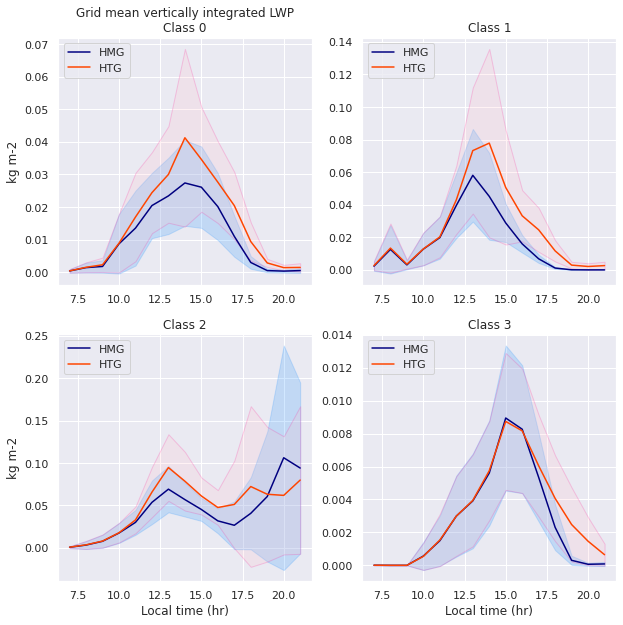

In [51]:
# CIlevel = 1.960   ## 95% CI
CIlevel = 1.645   ## 90% CI

fig,axs = plt.subplots(2,2, figsize=(10,10))
axs     = axs.ravel()


axs[0].plot(mean0.hour.values, mean0.lwp.sel(case='HMG').values, color = 'navy', label='HMG')
axs[0].fill_between(mean0.hour.values, 
                    mean0.lwp.sel(case='HMG').values - (CIlevel*se0.lwp.sel(case='HMG').values), 
                    mean0.lwp.sel(case='HMG').values + (CIlevel*se0.lwp.sel(case='HMG').values), 
                    alpha=0.2, facecolor='dodgerblue',edgecolor='dodgerblue')

axs[0].plot(mean0.hour.values, mean0.lwp.sel(case='HTG').values, color = 'orangered', label='HTG')
axs[0].fill_between(mean0.hour.values, 
                    mean0.lwp.sel(case='HTG').values - (CIlevel*se0.lwp.sel(case='HTG').values), 
                    mean0.lwp.sel(case='HTG').values + (CIlevel*se0.lwp.sel(case='HTG').values), 
                    alpha=0.2, facecolor='pink',edgecolor='deeppink')
axs[0].legend(loc='upper left')
axs[0].set_title('Grid mean vertically integrated LWP\nClass 0')
axs[0].set_ylabel(LES_allDays_allVars.lwp.units)



axs[1].plot(mean1.hour.values, mean1.lwp.sel(case='HMG').values, color = 'navy', label='HMG')
axs[1].fill_between(mean1.hour.values, 
                    mean1.lwp.sel(case='HMG').values - (CIlevel*se1.lwp.sel(case='HMG').values), 
                    mean1.lwp.sel(case='HMG').values + (CIlevel*se1.lwp.sel(case='HMG').values), 
                    alpha=0.2, facecolor='dodgerblue',edgecolor='dodgerblue')

axs[1].plot(mean1.hour.values, mean1.lwp.sel(case='HTG').values, color = 'orangered', label='HTG')
axs[1].fill_between(mean1.hour.values, 
                    mean1.lwp.sel(case='HTG').values - (CIlevel*se1.lwp.sel(case='HTG').values), 
                    mean1.lwp.sel(case='HTG').values + (CIlevel*se1.lwp.sel(case='HTG').values), 
                    alpha=0.2, facecolor='pink',edgecolor='deeppink')
axs[1].legend(loc='upper left')
axs[1].set_title('\nClass 1')


axs[2].plot(mean2.hour.values, mean2.lwp.sel(case='HMG').values, color = 'navy', label='HMG')
axs[2].fill_between(mean2.hour.values, 
                    mean2.lwp.sel(case='HMG').values - (CIlevel*se2.lwp.sel(case='HMG').values), 
                    mean2.lwp.sel(case='HMG').values + (CIlevel*se2.lwp.sel(case='HMG').values), 
                    alpha=0.2, facecolor='dodgerblue',edgecolor='dodgerblue')

axs[2].plot(mean2.hour.values, mean2.lwp.sel(case='HTG').values, color = 'orangered', label='HTG')
axs[2].fill_between(mean2.hour.values, 
                    mean2.lwp.sel(case='HTG').values - (CIlevel*se2.lwp.sel(case='HTG').values), 
                    mean2.lwp.sel(case='HTG').values + (CIlevel*se2.lwp.sel(case='HTG').values), 
                    alpha=0.2, facecolor='pink',edgecolor='deeppink')
axs[2].legend(loc='upper left')
axs[2].set_title('\nClass 2')
axs[2].set_xlabel('Local time (hr)')
axs[2].set_ylabel(LES_allDays_allVars.lwp.units)


axs[3].plot(mean3.hour.values, mean3.lwp.sel(case='HMG').values, color = 'navy', label='HMG')
axs[3].fill_between(mean3.hour.values, 
                    mean3.lwp.sel(case='HMG').values - (CIlevel*se3.lwp.sel(case='HMG').values), 
                    mean3.lwp.sel(case='HMG').values + (CIlevel*se3.lwp.sel(case='HMG').values), 
                    alpha=0.2, facecolor='dodgerblue',edgecolor='dodgerblue')

axs[3].plot(mean3.hour.values, mean3.lwp.sel(case='HTG').values, color = 'orangered', label='HTG')
axs[3].fill_between(mean3.hour.values, 
                    mean3.lwp.sel(case='HTG').values - (CIlevel*se3.lwp.sel(case='HTG').values), 
                    mean3.lwp.sel(case='HTG').values + (CIlevel*se3.lwp.sel(case='HTG').values), 
                    alpha=0.2, facecolor='pink',edgecolor='deeppink')
axs[3].legend(loc='upper left')
axs[3].set_title('\nClass 3')
axs[3].set_xlabel('Local time (hr)')



In [68]:
## Case 0 
# Get morning thl'2 at surface, compare to afternoon lwp? 

## ---- Get morning mean DSs ----
iMorning0    = np.where((les_class0['time.hour']>=7) & (les_class0['time.hour']<=10) )[0]
morning_LES0 = les_class0.isel(time=iMorning0, k=0) 
dayMean_morning_LES0 = morning_LES0.resample(time='1D').mean(dim='time').dropna(dim='time')

iMorning1    = np.where((les_class1['time.hour']>=7) & (les_class1['time.hour']<=10) )[0]
morning_LES1 = les_class1.isel(time=iMorning1, k=0) 
dayMean_morning_LES1 = morning_LES1.resample(time='1D').mean(dim='time').dropna(dim='time')

iMorning2    = np.where((les_class2['time.hour']>=7) & (les_class2['time.hour']<=10) )[0]
morning_LES2 = les_class2.isel(time=iMorning2, k=0) 
dayMean_morning_LES2 = morning_LES2.resample(time='1D').mean(dim='time').dropna(dim='time')

iMorning3    = np.where((les_class3['time.hour']>=7) & (les_class3['time.hour']<=10) )[0]
morning_LES3 = les_class3.isel(time=iMorning3, k=0) 
dayMean_morning_LES3 = morning_LES3.resample(time='1D').mean(dim='time').dropna(dim='time')


## ---- Get afternoon mean DSs ----
iAfternoon0    = np.where((les_class0['time.hour']>=12) & (les_class0['time.hour']<=19) )[0]  #1-7p
afternoon_LES0 = les_class0.isel(time=iAfternoon0, k=0) 
dayMean_afternoon_LES0 = afternoon_LES0.resample(time='1D').mean(dim='time').dropna(dim='time')

iAfternoon1    = np.where((les_class1['time.hour']>=12) & (les_class1['time.hour']<=19) )[0]  #1-7p
afternoon_LES1 = les_class1.isel(time=iAfternoon1, k=0) 
dayMean_afternoon_LES1 = afternoon_LES1.resample(time='1D').mean(dim='time').dropna(dim='time')

iAfternoon2    = np.where((les_class2['time.hour']>=12) & (les_class2['time.hour']<=19) )[0]  #1-7p
afternoon_LES2 = les_class2.isel(time=iAfternoon2, k=0) 
dayMean_afternoon_LES2 = afternoon_LES2.resample(time='1D').mean(dim='time').dropna(dim='time')

iAfternoon3    = np.where((les_class3['time.hour']>=12) & (les_class3['time.hour']<=19) )[0]  #1-7p
afternoon_LES3 = les_class3.isel(time=iAfternoon3, k=0) 
dayMean_afternoon_LES3 = afternoon_LES3.resample(time='1D').mean(dim='time').dropna(dim='time')



Text(0.6, 0.9, 'R = 0.09')

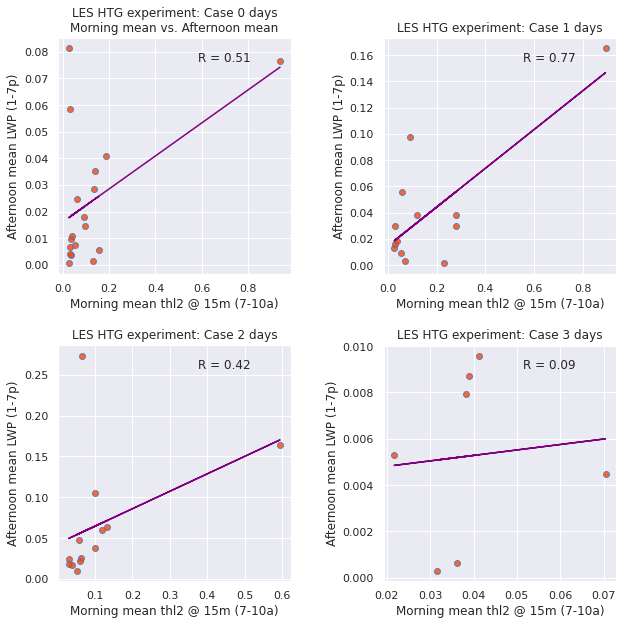

In [90]:
fig,axs = plt.subplots(2,2, figsize=(10,10))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.3,wspace=0.4)

axs[0].plot(dayMean_morning_LES0.sel(case='HTG').thl2.values, 
            dayMean_afternoon_LES0.sel(case='HTG').lwp.values,
            'o', alpha=0.8,markerfacecolor='orangered') 
axs[0].set_xlabel('Morning mean thl2 @ 15m (7-10a)')
axs[0].set_ylabel('Afternoon mean LWP (1-7p)')
axs[0].set_title('LES HTG experiment: Case 0 days\nMorning mean vs. Afternoon mean')

#obtain m (slope) and b(intercept) of linear regression line\
x = dayMean_morning_LES0.sel(case='HTG').thl2.values
y = dayMean_afternoon_LES0.sel(case='HTG').lwp.values
m, b = np.polyfit(x, y, 1)
#use red as color for regression line
axs[0].plot(x, m*x+b, color='purple')
r = np.corrcoef(x,y)
axs[0].text(0.6, 0.9, ('R = %.2f' % r[0,1]), transform=axs[0].transAxes)


axs[1].plot(dayMean_morning_LES1.sel(case='HTG').thl2.values, 
            dayMean_afternoon_LES1.sel(case='HTG').lwp.values,
            'o', alpha=0.8,markerfacecolor='orangered') 
axs[1].set_xlabel('Morning mean thl2 @ 15m (7-10a)')
axs[1].set_ylabel('Afternoon mean LWP (1-7p)')
axs[1].set_title('LES HTG experiment: Case 1 days')
x = dayMean_morning_LES1.sel(case='HTG').thl2.values
y = dayMean_afternoon_LES1.sel(case='HTG').lwp.values
m, b = np.polyfit(x, y, 1)
#use red as color for regression line
axs[1].plot(x, m*x+b, color='purple')
r = np.corrcoef(x,y)
axs[1].text(0.6, 0.9, ('R = %.2f' % r[0,1]), transform=axs[1].transAxes)


axs[2].plot(dayMean_morning_LES2.sel(case='HTG').thl2.values, 
            dayMean_afternoon_LES2.sel(case='HTG').lwp.values,
            'o', alpha=0.8,markerfacecolor='orangered') 
axs[2].set_xlabel('Morning mean thl2 @ 15m (7-10a)')
axs[2].set_ylabel('Afternoon mean LWP (1-7p)')
axs[2].set_title('LES HTG experiment: Case 2 days')
x = dayMean_morning_LES2.sel(case='HTG').thl2.values
y = dayMean_afternoon_LES2.sel(case='HTG').lwp.values
m, b = np.polyfit(x, y, 1)
#use red as color for regression line
axs[2].plot(x, m*x+b, color='purple')
r = np.corrcoef(x,y)
axs[2].text(0.6, 0.9, ('R = %.2f' % r[0,1]), transform=axs[2].transAxes)

axs[3].plot(dayMean_morning_LES3.sel(case='HTG').thl2.values, 
            dayMean_afternoon_LES3.sel(case='HTG').lwp.values,
            'o', alpha=0.8,markerfacecolor='orangered') 
axs[3].set_xlabel('Morning mean thl2 @ 15m (7-10a)')
axs[3].set_ylabel('Afternoon mean LWP (1-7p)')
axs[3].set_title('LES HTG experiment: Case 3 days')
x = dayMean_morning_LES3.sel(case='HTG').thl2.values
y = dayMean_afternoon_LES3.sel(case='HTG').lwp.values
m, b = np.polyfit(x, y, 1)
#use red as color for regression line
axs[3].plot(x, m*x+b, color='purple')
r = np.corrcoef(x,y)
axs[3].text(0.6, 0.9, ('R = %.2f' % r[0,1]), transform=axs[3].transAxes)


## Scratch

*What about this interesting PCM stuff?*<br>
https://github.com/obidam/pcm<br>
Paper: Maze et al. (2017) "Coherent heat patterns revealed by unsupervised classification of Argo temperature profiles in the North Atlantic Ocean"

In [19]:
import os
import numpy as np
import xarray, dask
import matplotlib.pyplot as plt
import matplotlib as mpl
# from mpl_toolkits.basemap import Basemap as bm
import pandas as pd

# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn import preprocessing

# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA

# http://scikit-learn.org/stable/modules/mixture.html
from sklearn.mixture import GaussianMixture

import seaborn as sns


In [20]:
# Define usefull functions:
def vrange(V): # Return the array value range
    return [np.min(V),np.max(V)]
def vrangec(V): # Return the array value centered range 
    xl = np.max(np.abs(vrange(V)))
    return np.array([-xl,xl])

In [21]:
# Number of GMM classes to compute:
K = 4

# Compression level for the dimensionality reduction 
maxvar = 99.9 # in %


In [22]:
# And Create the array X(Nz,Np): The field to classify with a GMM, 
# Np profiles with Nz depth levels.
X = mornMeanPBL['T'].values
DPTmodel = mornMeanPBL['lev'].values

# Size of the training set X:
[Np, Nz] = X.shape
print('Number of raw features (Depth Levels): ', Nz)
print('Number of samples (N profiles): ', Np)

Number of raw features (Depth Levels):  13
Number of samples (N profiles):  338


**Normalize**

In [23]:
## Normalize...

# Fit the scaler object:
scaler = preprocessing.StandardScaler()
scaler = scaler.fit(X)

# The mean and std profiles are in the scaler object properties:
X_ave = scaler.mean_
X_std = scaler.scale_

# Normalize data:
Xn = scaler.transform(X)       

# Here, we only center data:
Xc = preprocessing.StandardScaler(with_std=False).fit(X).transform(X)

# Compute additional statistics, like the observed PDFz:
def diag_pdfz(X,xedges):
    Nz = X.shape[1]
    PDFz = np.zeros((xedges.shape[0]-1,Nz))
    for iz in np.arange(Nz):
        h, hx = np.histogram(X[:,iz],bins=xedges,density=True)
        PDFz[:,iz] = h
    PDFz_axis = hx[0:-1]
    return PDFz, PDFz_axis
# PDFz, PDFz_axis = diag_pdfz(X,np.arange(0,30,0.2))
PDFz, PDFz_axis = diag_pdfz(X,np.arange(275,310,0.5))



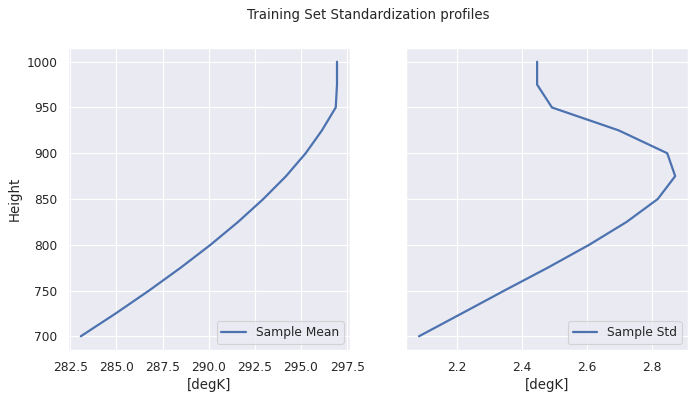

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey='row', figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')
ax[0].plot(X_ave, DPTmodel, '-', linewidth=2,label='Sample Mean')
ax[1].plot(X_std, DPTmodel, '-', linewidth=2,label='Sample Std')
# tidy up the figure
ax[0].set_ylabel('Height')
for ix in range(0,2):
    ax[ix].legend(loc='lower right')
    ax[ix].grid(True)
    ax[ix].set_xlabel('[degK]')
fig.suptitle('Training Set Standardization profiles', fontsize=12)
plt.show()


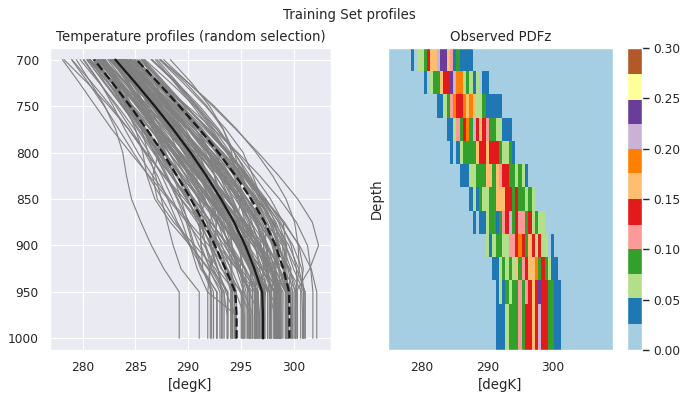

In [95]:
# Select 100 random profiles:
n = 150
ip = np.unique(np.random.randint(0,Np-1,n))

# Random selection of profiles
fig, ax = plt.subplots(nrows=1, ncols=2, sharey='row', figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')
ax[0].plot(X[ip,:].T, np.reshape(np.repeat(DPTmodel,ip.shape[0]),[Nz,ip.shape[0]]), '-', color='gray', linewidth=1)
ax[0].plot(np.mean(X[ip,:].T,axis=1), DPTmodel, '-', color='k', linewidth=2)
ax[0].plot(np.mean(X[ip,:].T,axis=1)-np.std(X[ip,:].T,axis=1), DPTmodel, '--', color='k', linewidth=2)
ax[0].plot(np.mean(X[ip,:].T,axis=1)+np.std(X[ip,:].T,axis=1), DPTmodel, '--', color='k', linewidth=2)
ax[0].grid(True)
ax[0].set_title('Temperature profiles (random selection)')
ax[0].set_xlabel('[degK]')
ax[0].invert_yaxis()

cmap = plt.get_cmap('Paired',lut=128)
df = xarray.DataArray(PDFz.T, coords=[DPTmodel,PDFz_axis], dims=['Depth','[degK]'])
p = df.plot(cmap=cmap,vmin=0,vmax=0.3,ax=ax[1])
# p = df.plot(cmap=cmap,ax=ax[1])
ax[1].set_title("Observed PDFz")
ax[1].invert_yaxis()

fig.suptitle('Training Set profiles', fontsize=12)
plt.show()

**Data Reduction**

In [92]:
# # Compute P (the EOFs) from x:
# reducer = PCA(n_components=maxvar/100,svd_solver='full')
# reducer.fit(Xn)

# # Reduce the dataset (compute the y):
# Xr = reducer.transform(Xn) # Here we compute: np.dot(Xn - reducer.mean_, np.transpose(reducer.components_))

# # Variables of the reduced space:
# Nc = reducer.n_components_ # Number of components retained
# EOFs = reducer.components_ # [Nc , Nz], the P matrix
# V = reducer.explained_variance_ratio_ # Explained variance, with 0 to 1 values

# # We can also compute EOFs with real units this way:
# S = np.sqrt(reducer.explained_variance_*Xn.shape[0]) # These are the singular values
# Z = np.dot(Xn - reducer.mean_, np.transpose(reducer.components_)) # This is simply Xr or the principal components
# Ztilde = Z/np.sqrt(S) # Normalized PCs
# #EOFs_real = np.dot(np.transpose(Ztilde),X)/X.shape[0] # Regression on any collection of profiles
# EOFs_realc = np.dot(np.transpose(Ztilde),Xc)/Xc.shape[0] # Regression on any collection of profiles
# EOFs_real = np.dot(np.transpose(Ztilde),Xn)/Xn.shape[0] # Regression on any collection of profiles

# # Compute the RMS difference between the reconstructed and original dataset:
# Xn_reconstructed = reducer.inverse_transform(Xr)
# X_reconstructed = scaler.inverse_transform(Xn_reconstructed)
# rms = np.sqrt(np.mean(np.square(X_reconstructed-X),axis=0))

# #
# print('\nWe reduced the dimensionality of the problem from %i depth levels down to %i PCs\n' %(Nz,Nc))


We reduced the dimensionality of the problem from 13 depth levels down to 6 PCs



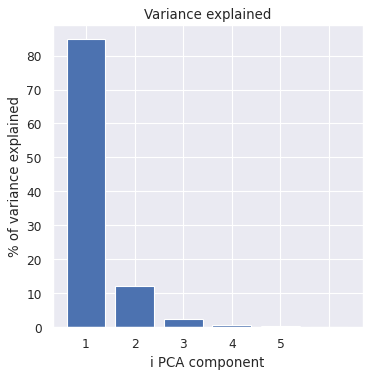

In [93]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
# ax.bar(range(0,Nc),V*100)
# ax.set_xlabel('i PCA component')
# ax.set_ylabel('% of variance explained')
# ax.grid(True)
# ax.set_xticklabels(range(0,Nc))
# ax.set_title('Variance explained')
# plt.show()


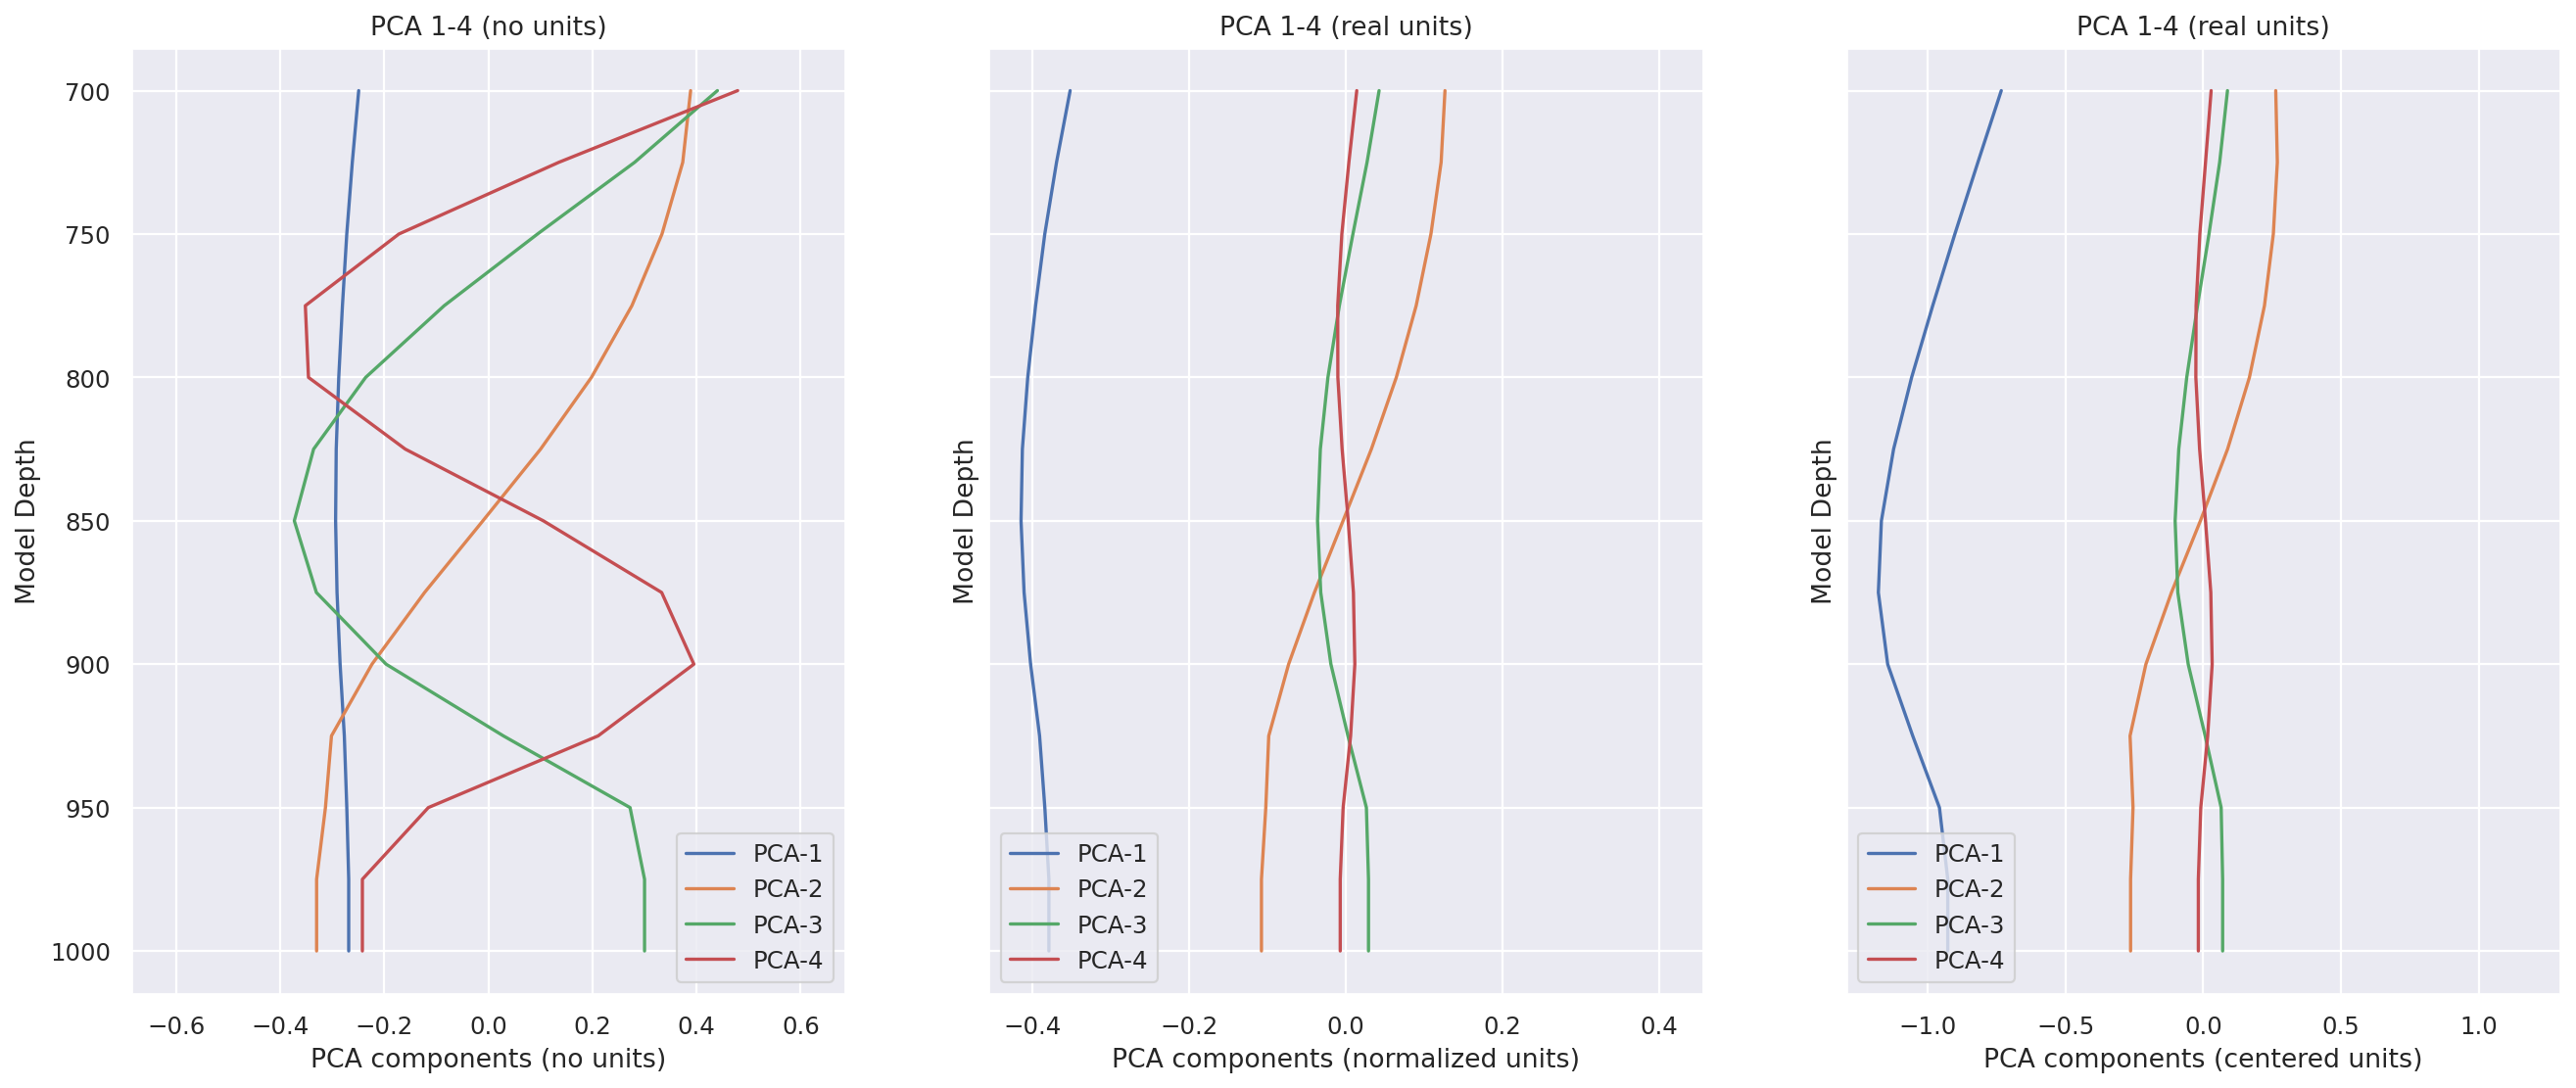

In [97]:
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,8), dpi=160, facecolor='w', edgecolor='k', sharey='row')

# iax = 0
# xl = np.max(np.abs([np.min(EOFs),np.max(EOFs)]))
# for ie in range(0,4):
#     ax[iax].plot(np.transpose(EOFs[ie,:]),DPTmodel,label="PCA-%i"%(ie+1))
# ax[iax].set_xlim(1.1*np.array([-xl,xl]))
# ax[iax].legend(loc='lower right')
# ax[iax].set_xlabel('PCA components (no units)')
# ax[iax].set_ylabel('Model Depth')
# ax[iax].grid(True)
# ax[iax].set_title('PCA 1-4 (no units)')
# ax[iax].invert_yaxis()

# iax+=1
# xl = np.max(np.abs([np.min(EOFs_real),np.max(EOFs_real)]))
# for ie in range(0,4):
#     ax[iax].plot(np.transpose(EOFs_real[ie,:]),DPTmodel,label="PCA-%i"%(ie+1))
# ax[iax].set_xlim(1.1*np.array([-xl,xl]))
# ax[iax].legend(loc='lower left')
# ax[iax].set_xlabel('PCA components (normalized units)')
# ax[iax].set_ylabel('Model Depth')
# ax[iax].grid(True)
# ax[iax].set_title('PCA 1-4 (real units)')
# ax[iax].invert_yaxis()


# iax+=1
# xl = np.max(np.abs([np.min(EOFs_realc),np.max(EOFs_realc)]))
# for ie in range(0,4):
#     ax[iax].plot(np.transpose(EOFs_realc[ie,:]),DPTmodel,label="PCA-%i"%(ie+1))
# ax[iax].set_xlim(1.1*np.array([-xl,xl]))
# ax[iax].legend(loc='lower left')
# ax[iax].set_xlabel('PCA components (centered units)')
# ax[iax].set_ylabel('Model Depth')
# ax[iax].grid(True)
# ax[iax].set_title('PCA 1-4 (real units)')
# ax[iax].invert_yaxis()


# plt.show()

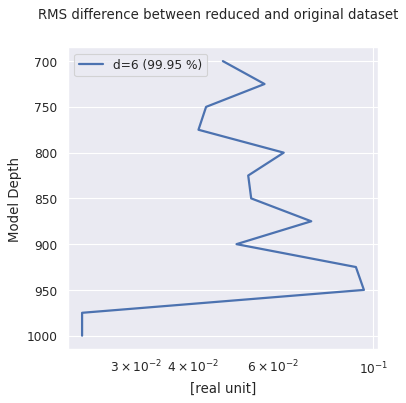

In [98]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')

# ax.semilogx(rms, DPTmodel, '-', linewidth=2,label="d=%i (%0.2f %%)"%(Nc,np.sum(V*100)))

# # tidy up the figure
# ax.legend(loc='upper left')
# # ax.set_xticks([0.0125,0.025,0.05,0.1,0.25,0.5,1])
# # ax.set_xlim([1e-3,1e1])
# ax.set_xlabel('[real unit]')
# ax.set_ylabel('Model Depth')
# ax.grid(True)
# ax.invert_yaxis()
# fig.suptitle('RMS difference between reduced and original dataset', fontsize=12)
# plt.show()


**GMM Classification**

In [99]:
# # Set-up and train the classifier:
# gmm = GaussianMixture(n_components=K,\
#                       covariance_type='full',\
#                       init_params='kmeans',\
#                       max_iter=1000,\
#                       tol=1e-6)
# gmm.fit(Xr) # Training on reduced data

# # Extract GMM parameters:
# priors = gmm.weights_ # [K,1]
# centers= gmm.means_   # [K,Nc]
# covars = gmm.covariances_ # [K,Nc,Nc] if 'full'

# # Classify the dataset:
# LABELS = gmm.predict(Xr) # [Np,1]
# POST   = gmm.predict_proba(Xr) # [Np,Nc]


In [25]:
# Set-up and train the classifier:
gmm = GaussianMixture(n_components=K,\
                      covariance_type='full',\
                      init_params='kmeans',\
                      max_iter=1000,\
                      tol=1e-6)
gmm.fit(Xn) # Training on normalized data

# Extract GMM parameters:
priors = gmm.weights_ # [K,1]
centers= gmm.means_   # [K,Nc]
covars = gmm.covariances_ # [K,Nc,Nc] if 'full'

# Classify the dataset:
LABELS = gmm.predict(Xn) # [Np,1]
POST   = gmm.predict_proba(Xn) # [Np,Nc]


In [115]:
np.shape(Xn)

(338, 13)

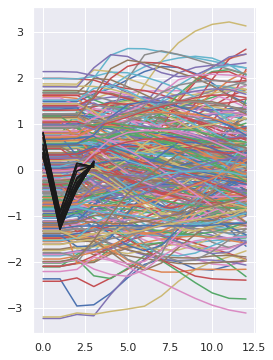

In [26]:
fig,axs = plt.subplots(1,1,figsize=(4,6))

for iDay in range(338):
    axs.plot(Xn[iDay,:])
    
axs.plot(centers,'k')


In [110]:
np.shape(centers)

(8, 13)

*Playing around with k-mean clustering of large scale forcing data*

In [ ]:
ax = sns.scatterplot(data = forcDS_JJAnoon, 
                     x = 'vertInt_T_adv_h', 
                     y = 'vertInt_Q_adv_h',
                     s = 150)



ValueError: Data must be 1-dimensional

In [39]:
forcDS_JJAnoon[['vertInt_T_adv_h', 'vertInt_Q_adv_h']]

<xarray.Dataset>
Dimensions:          (time: 2565)
Coordinates:
  * time             (time) datetime64[ns] 2015-06-01T13:00:00 ... 2018-08-31...
Data variables:
    vertInt_T_adv_h  (time) float64 -0.1597 -0.2561 -0.3219 ... 0.1233 0.1233
    vertInt_Q_adv_h  (time) float64 -0.1126 -0.1218 ... -0.00627 -0.00627
Attributes:
    Conventions:                CF-1.7
    title:                      VarAna 1hr RAP_Based v2: SGP 2015-01
    history:                    Tue Dec  1 17:20:52 2020: ncap2 -s bdate=2015...
    update:                     surface LH and SH are merged from ECOR and EB...
    date_created:               Thu Apr 13 20:12:17 2017
    contact:                    Shuaiqi Tang: tang32@llnl.gov, Qi Tang: tang3...
    program_name:               proc_output_nwp.pro
    institution:                Lawrence Livermore National Laboratory, CA, USA
    references:                 https://www.arm.gov/data/data-sources/varanal-29
    note:                       Data below the surface are set to lowest avai...
    NCO:                        netCDF Operators version 4.7.5 (Homepage = ht...
    missing_value:              -9999.0
    iop_file:                   ./SAS_ideal_4scam.nc
    publication:                https://doi.org/10.5194/acp-16-7725-2016
    creation_date:              Rich Neale, NCAR
    nco_openmp_thread_number:   1
    history_of_appended_files:  Tue Dec  1 17:20:52 2020: Appended file ../CL...

In [14]:
# vertIntDF = forcDS_JJAnoon[['vertInt_T_adv_h', 'vertInt_Q_adv_h']].to_dataframe()
# vertIntDF.describe().round(2)

vertT = forcDS_JJAmornPBL[['T', 'lev']].to_dataframe()
vertT.describe().round(2)


,T,lat,lon
count,28704.00,28704.00,28704.00
mean,291.85,36.62,-97.50
std,5.37,0.01,0.01
min,276.40,36.61,-97.49
25%,287.65,36.61,-97.49
50%,292.41,36.61,-97.49
75%,296.19,36.61,-97.49
max,304.73,36.61,-97.49


In [17]:
vertT_scaled

array([[-0.70709664,  0.        ,  0.        ],
       [-0.5310354 ,  0.        ,  0.        ],
       [-0.27197292,  0.        ,  0.        ],
       ...,
       [-1.1669719 ,  0.        ,  0.        ],
       [-1.1846524 ,  0.        ,  0.        ],
       [-1.1857656 ,  0.        ,  0.        ]], dtype=float32)

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

vertT_scaled = scaler.fit_transform(vertT)  ## Returns a numpy array, so convert to a DF
vertT_scaled = pd.DataFrame(vertT_scaled, columns = ['T', 'lev'])



ValueError: Shape of passed values is (28704, 3), indices imply (28704, 2)

In [44]:
vertInt_scaled.describe().round(2)

,vertInt_T_adv_h,vertInt_Q_adv_h
count,2565.00,2565.00
mean,-0.00,-0.00
std,1.00,1.00
min,-3.86,-3.29
25%,-0.60,-0.61
50%,0.01,-0.13
75%,0.60,0.50
max,4.60,4.17


In [45]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 3, n_init = 25, random_state = 1234) 

# Set k = 3
# Number of times to run algorithm with different centroid seeds; defualt = 10
# Random initialization seed; setting this allows us to reproduce results 

km.fit(vertInt_scaled)


KMeans(n_clusters=3, n_init=25, random_state=1234)

In [46]:
km.inertia_
# Total within cluster sum of squares (WCSS)

2583.0690952999003

In [49]:
pd.Series(km.labels_).value_counts().sort_index()

cluster_centers = pd.DataFrame(km.cluster_centers_, 
                               columns = ['vertInt_T_adv_h', 'vertInt_Q_adv_h'])
cluster_centers


,vertInt_T_adv_h,vertInt_Q_adv_h
0,0.546078,-0.454120
1,-0.944986,-0.146077
2,0.449342,1.498415


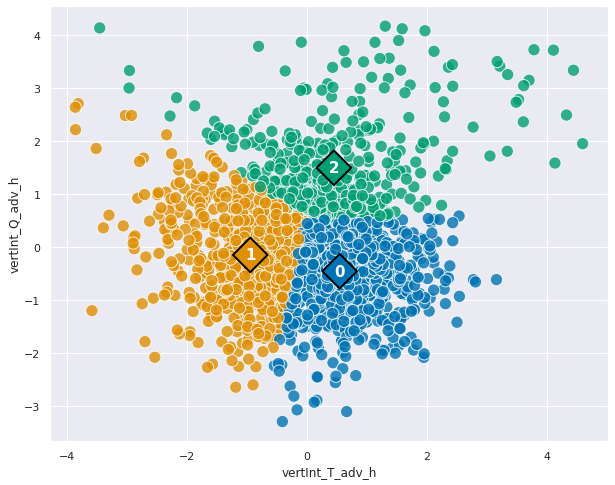

In [50]:
# Set the figure size
plt.figure(figsize=(10, 8))

#Plot the Clusters
ax = sns.scatterplot(data = vertInt_scaled,
                     x = 'vertInt_T_adv_h',
                     y = 'vertInt_Q_adv_h', 
                     hue = km.labels_, 
                     palette = 'colorblind', 
                     alpha = 0.8, 
                     s = 150,
                     legend = False)

#Plot the Centroids
ax = sns.scatterplot(data = cluster_centers, 
                     x = 'vertInt_T_adv_h',
                     y = 'vertInt_Q_adv_h', 
                     hue = cluster_centers.index, 
                     palette = 'colorblind', 
                     s = 600,
                     marker = 'D',
                     ec = 'black', 
                     legend = False)

# Add Centroid Labels
for i in range(len(cluster_centers)):
               plt.text(x = cluster_centers.vertInt_T_adv_h[i], 
                        y = cluster_centers.vertInt_Q_adv_h[i],
                        s = i, 
                        horizontalalignment='center',
                        verticalalignment='center',
                        size = 15,
                        weight = 'bold',
                        color = 'white')
        
# First cluster could benefit from additional partitioning 
        

**Figure out appropriate number of clusters**

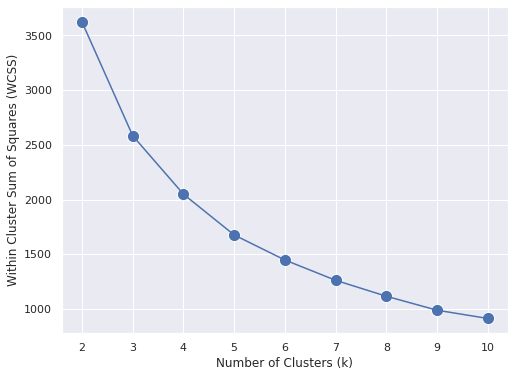

In [51]:
wcss = []
for k in range(2, 11):        # Iterate over k values of 2 through 10
    km = KMeans(n_clusters = k, n_init = 25, random_state = 1234)
    km.fit(vertInt_scaled)
    wcss.append(km.inertia_)  # Inertia attributa = WCSS for this km

wcss_series = pd.Series(wcss, index = range(2, 11))

plt.figure(figsize=(8, 6))
ax = sns.lineplot(y = wcss_series, x = wcss_series.index)
ax = sns.scatterplot(y = wcss_series, x = wcss_series.index, s = 150)
ax = ax.set(xlabel = 'Number of Clusters (k)', 
            ylabel = 'Within Cluster Sum of Squares (WCSS)')

# Most approporiate k = 5


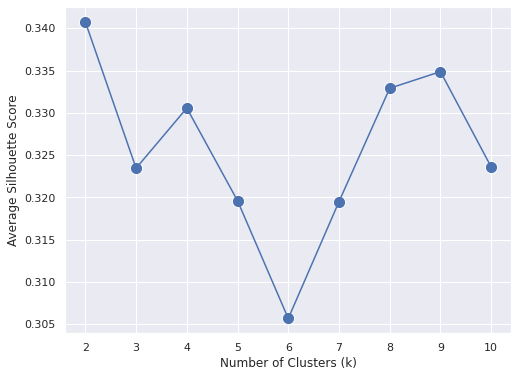

In [52]:
from sklearn.metrics import silhouette_score

silhouette = []
for k in range(2, 11):
    km = KMeans(n_clusters = k, n_init = 25, random_state = 1234)
    km.fit(vertInt_scaled)                                           
    silhouette.append(silhouette_score(vertInt_scaled, km.labels_))  # Pass data and labels to silhouette_score

silhouette_series = pd.Series(silhouette, index = range(2, 11))

plt.figure(figsize=(8, 6))
ax = sns.lineplot(y = silhouette_series, x = silhouette_series.index)
ax = sns.scatterplot(y = silhouette_series, x = silhouette_series.index, s = 150)
ax = ax.set(xlabel = 'Number of Clusters (k)', 
            ylabel = 'Average Silhouette Score')

# Most appropriate k = 5 again 


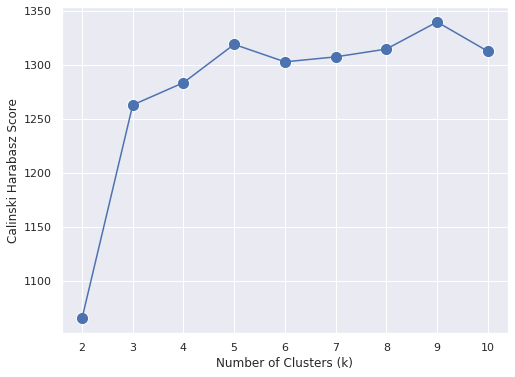

In [53]:
from sklearn.metrics import calinski_harabasz_score

calinski = []
for k in range(2, 11):
    km = KMeans(n_clusters = k, n_init = 25, random_state = 1234)
    km.fit(vertInt_scaled)
    calinski.append(calinski_harabasz_score(vertInt_scaled, km.labels_))

calinski_series = pd.Series(calinski, index = range(2, 11))

plt.figure(figsize=(8, 6))
ax = sns.lineplot(y = calinski_series, x = calinski_series.index)
ax = sns.scatterplot(y = calinski_series, x = calinski_series.index, s = 150)
ax = ax.set(xlabel = 'Number of Clusters (k)', 
            ylabel = 'Calinski Harabasz Score')


In [54]:
km = KMeans(n_clusters = 5, n_init = 25, random_state = 1234) 
km.fit(vertInt_scaled)


KMeans(n_clusters=5, n_init=25, random_state=1234)

In [56]:
cluster_centers = pd.DataFrame(km.cluster_centers_, columns = ['vertInt_T_adv_h', 'vertInt_Q_adv_h'])
cluster_centers

,vertInt_T_adv_h,vertInt_Q_adv_h
0,0.928984,-0.619820
1,-1.438811,1.004559
2,1.255848,2.210215
3,-0.691671,-0.763468
4,0.107625,0.339948


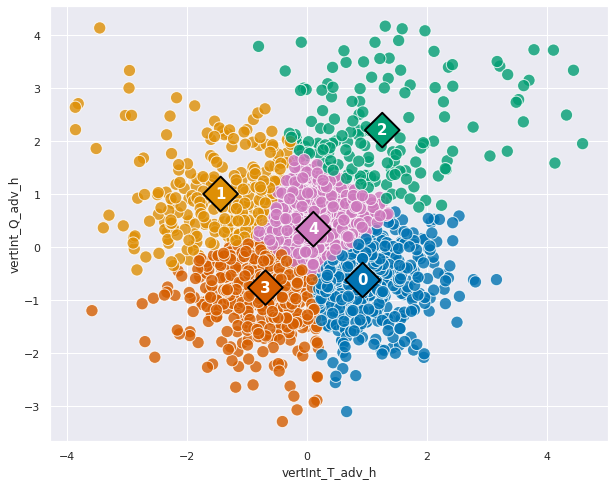

In [57]:
# Set the figure size
plt.figure(figsize=(10, 8))

#Plot the Clusters
ax = sns.scatterplot(data = vertInt_scaled,
                     x = 'vertInt_T_adv_h',
                     y = 'vertInt_Q_adv_h', 
                     hue = km.labels_, 
                     palette = 'colorblind', 
                     alpha = 0.8, 
                     s = 150,
                     legend = False)

#Plot the Centroids
ax = sns.scatterplot(data = cluster_centers, 
                     x = 'vertInt_T_adv_h',
                     y = 'vertInt_Q_adv_h', 
                     hue = cluster_centers.index, 
                     palette = 'colorblind', 
                     s = 600,
                     marker = 'D',
                     ec = 'black', 
                     legend = False)

# Add Centroid Labels
for i in range(len(cluster_centers)):
               plt.text(x = cluster_centers.vertInt_T_adv_h[i], 
                        y = cluster_centers.vertInt_Q_adv_h[i],
                        s = i, 
                        horizontalalignment='center',
                        verticalalignment='center',
                        size = 15,
                        weight = 'bold',
                        color = 'white')
        
# First cluster could benefit from additional partitioning 
        